**Introduction**  
In this work will be conducted research, analysis of dataset that contains records from chemical sensors, regression modeling of target variable, model analysis.

Features description:
- Date: (DD/MM/YYYY), date of record
- Time: (HH.MM.SS), time of record
- CO(GT): True hourly averaged concentration CO in mg/m^3 (reference analyzer)
- PT08.S1: (tin oxide) hourly averaged sensor response (nominally CO targeted)
- NMHC(GT): True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)
- PT08.S2: (titania) hourly averaged sensor response (nominally NMHC targeted)
- NOx(GT): True hourly averaged NOx concentration in ppb (reference analyzer)
- PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)
- NO2(GT): True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)
- PT08.S4: (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)
- PT08.S5: (indium oxide) hourly averaged sensor response (nominally O3 targeted)
- T: Temperature in °C
- RH: Relative Humidity (%)
- AH: Absolute Humidity

Target variable:
- C6H6(GT): True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

Loading dataset

In [ ]:
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/HW2/AirQualityUCI.csv'

data = pd.read_csv(file_path, sep=';')
data = data.iloc[:9357, :15]
data.head()

ValueError: mount failed

First glance at dataset. Can be see that numerical values in features CO(GT), C6H6(GT), T, RH, AH are not correctly recorded using "," as delimiter in numeric values, but not "." Date is also can converted to correct Date format, as well as Time to appropriate format.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
dtypes: float64(8), object(7)
memory usage: 1.1+ MB


In [ ]:
columns_to_convert = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']
data[columns_to_convert] = data[columns_to_convert].replace(',', '.', regex=True).astype('float64')
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data['Time'] = pd.to_datetime(data['Time'], format='%H.%M.%S').dt.time

Feature Date was converted to suitable date format. Features CO(GT), C6H6(GT), T, RH, AH that were of type object were converted to type float64 as they are numeric.

In [ ]:
data = data.replace(-200, np.nan)

Replaced holder for Nan values in whole dataframe.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9357 non-null   datetime64[ns]
 1   Time           9357 non-null   object        
 2   CO(GT)         7674 non-null   float64       
 3   PT08.S1(CO)    8991 non-null   float64       
 4   NMHC(GT)       914 non-null    float64       
 5   C6H6(GT)       8991 non-null   float64       
 6   PT08.S2(NMHC)  8991 non-null   float64       
 7   NOx(GT)        7718 non-null   float64       
 8   PT08.S3(NOx)   8991 non-null   float64       
 9   NO2(GT)        7715 non-null   float64       
 10  PT08.S4(NO2)   8991 non-null   float64       
 11  PT08.S5(O3)    8991 non-null   float64       
 12  T              8991 non-null   float64       
 13  RH             8991 non-null   float64       
 14  AH             8991 non-null   float64       
dtypes: datetime64[ns](1),

We see that there is a lot of missing values in column NMHC(GT). And relatively small amount of missing values contain all other columns, except columns: Date and Time.

**EDA**   
**Univariate analysis**



In [ ]:
numeric_columns = data.select_dtypes(include=['number'])
numeric_columns.describe()

CO(GT)  PT08.S1(CO)     NMHC(GT)     C6H6(GT)  PT08.S2(NMHC)  \
count  7674.000000  8991.000000   914.000000  8991.000000    8991.000000   
mean      2.152750  1099.833166   218.811816    10.083105     939.153376   
std       1.453252   217.080037   204.459921     7.449820     266.831429   
min       0.100000   647.000000     7.000000     0.100000     383.000000   
25%       1.100000   937.000000    67.000000     4.400000     734.500000   
50%       1.800000  1063.000000   150.000000     8.200000     909.000000   
75%       2.900000  1231.000000   297.000000    14.000000    1116.000000   
max      11.900000  2040.000000  1189.000000    63.700000    2214.000000   

           NOx(GT)  PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
count  7718.000000   8991.000000  7715.000000   8991.000000  8991.000000   
mean    246.896735    835.493605   113.091251   1456.264598  1022.906128   
std     212.979168    256.817320    48.370108    346.206794   398.484288   
min       2.000000    322.000000     2.000000    551.000000   221.000000   
25%      98.000000    658.000000    78.000000   1227.000000   731.500000   
50%     180.000000    806.000000   109.000000   1463.000000   963.000000   
75%     326.000000    969.500000   142.000000   1674.000000  1273.500000   
max    1479.000000   2683.000000   340.000000   2775.000000  2523.000000   

                 T           RH           AH  
count  8991.000000  8991.000000  8991.000000  
mean     18.317829    49.234201     1.025530  
std       8.832116    17.316892     0.403813  
min      -1.900000     9.200000     0.184700  
25%      11.800000    35.800000     0.736800  
50%      17.800000    49.600000     0.995400  
75%      24.400000    62.500000     1.313700  
max      44.600000    88.700000     2.231000

No feature has extremely small standard deviation value in dataset.
All features except T (temperature) take on only positive values. Not any feature except (T) takes on value of zero, it is considrable remark which we can use during feature transformations.

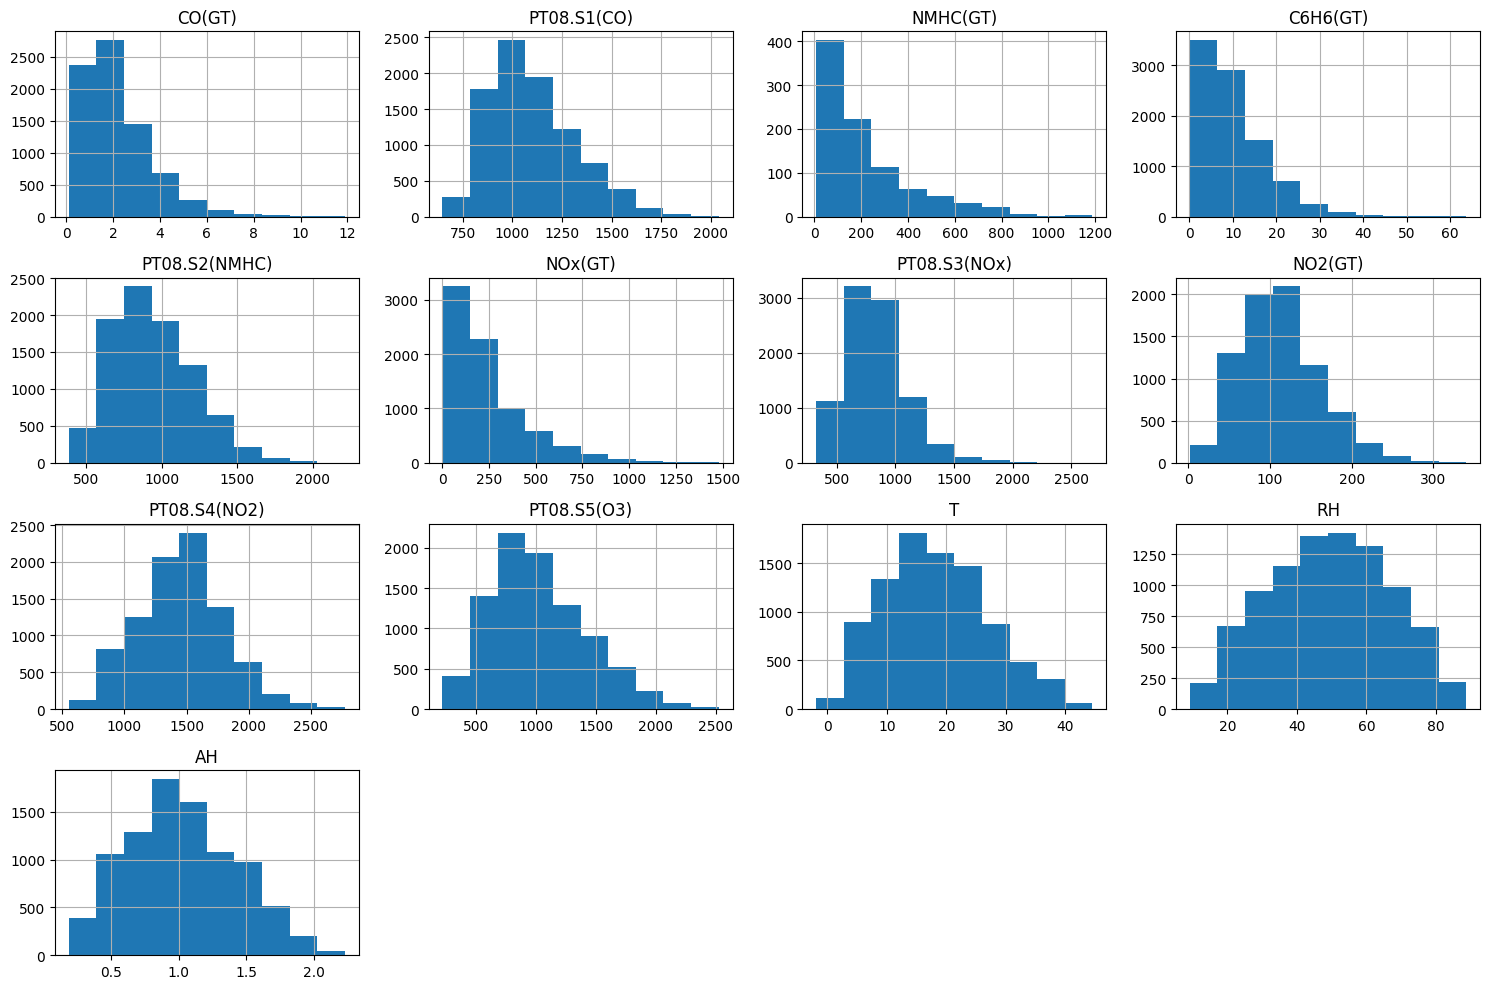

In [ ]:
data.select_dtypes(include='number').hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

We see that all features except RH are fairly right skewed. No evidence found for any feature to be normaly distributed. Distribution of feature RH seems to be almost symmetrical.

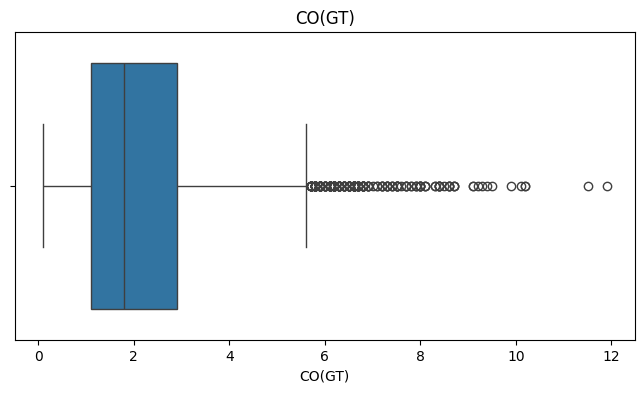

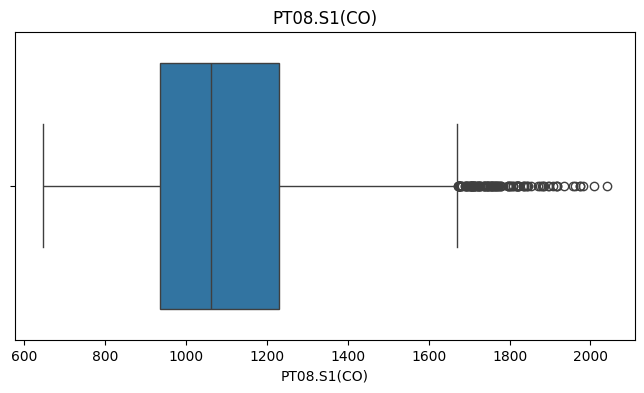

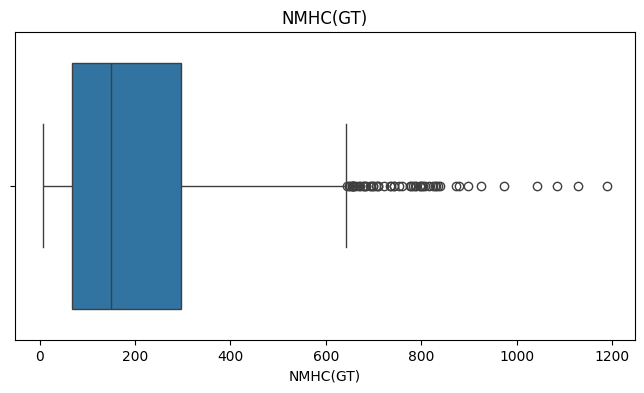

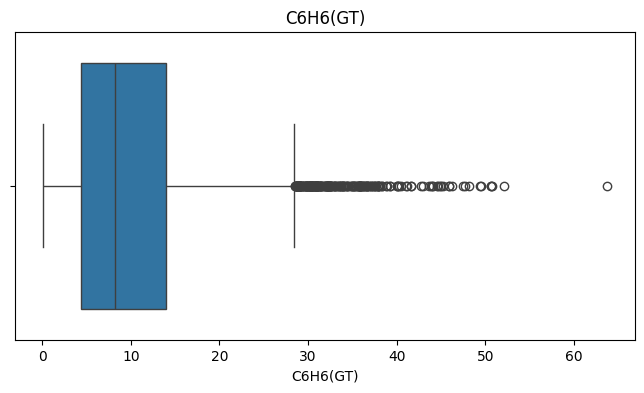

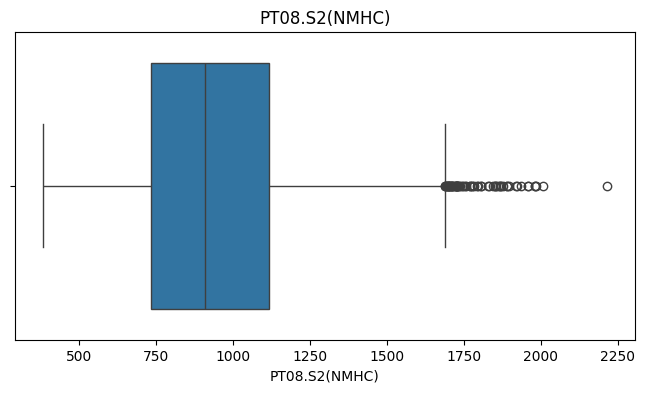

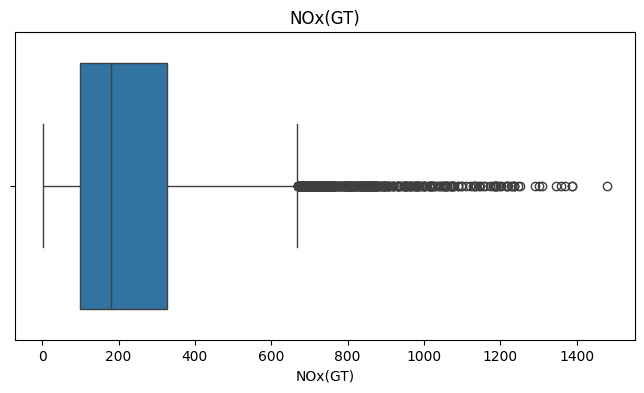

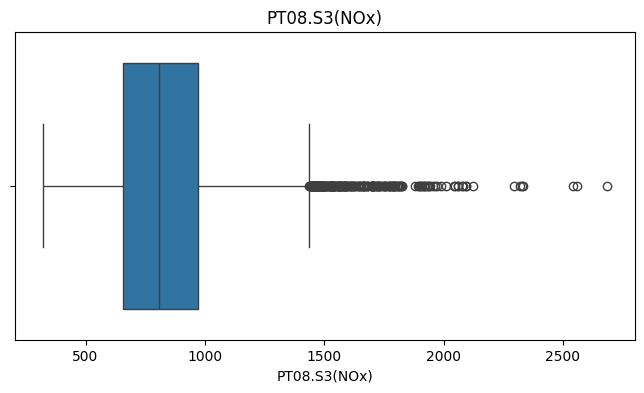

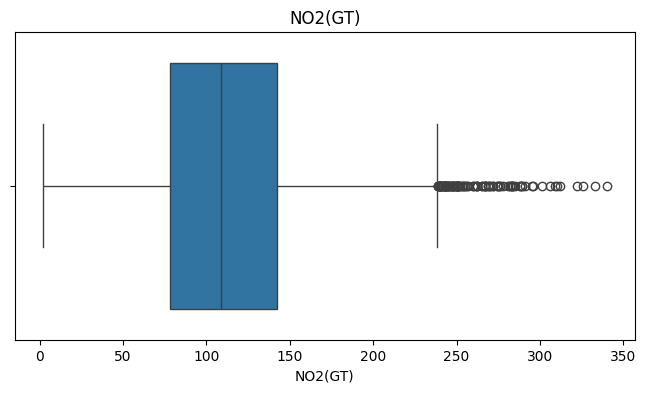

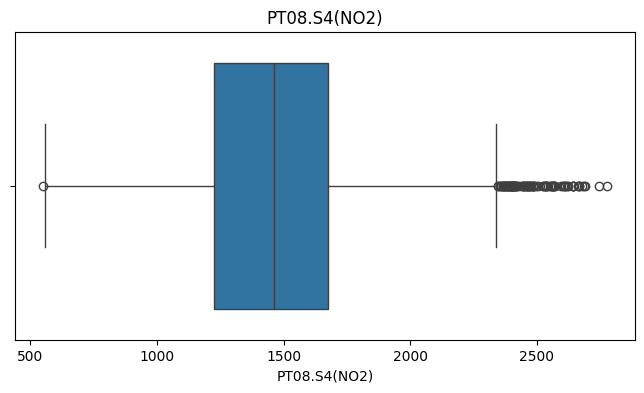

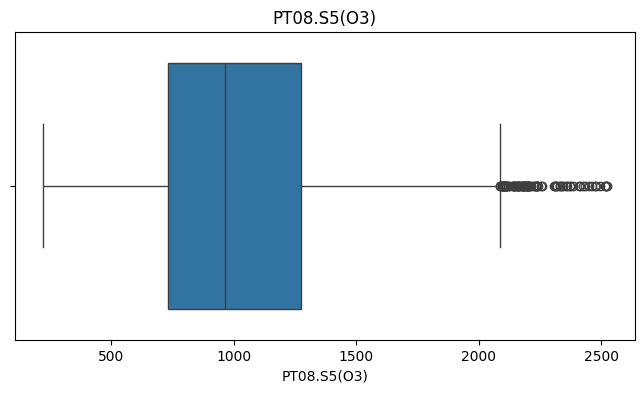

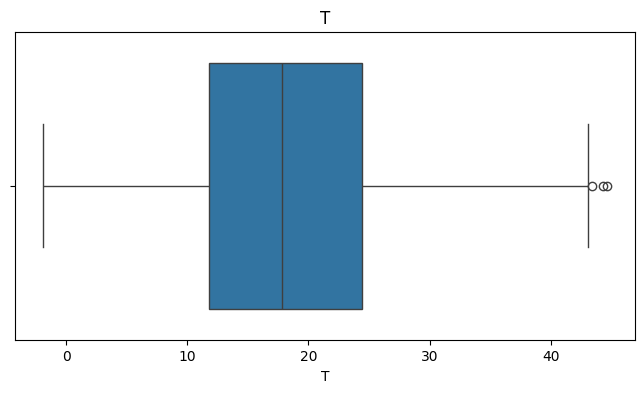

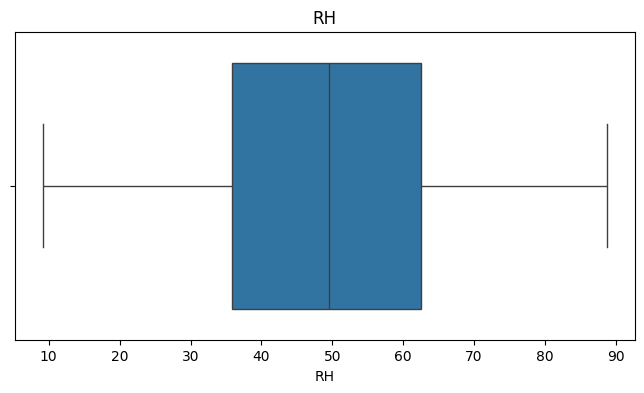

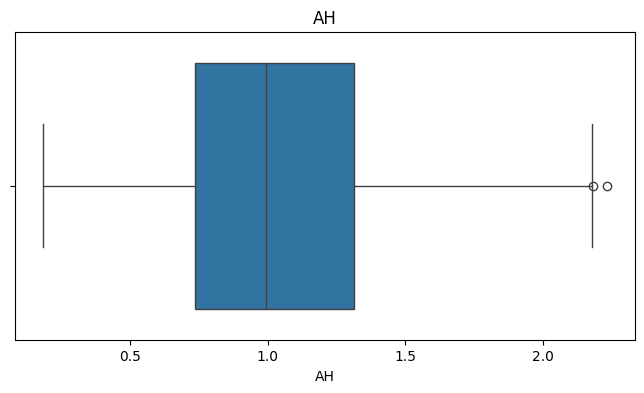

In [ ]:
for column in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[column])
    plt.title(column)
    plt.show()

All features contain outliers, except one - RH.

In [ ]:
missing_percentage = data.isnull().mean() * 100
print(missing_percentage)
print()

Date              0.000000
Time              0.000000
CO(GT)           17.986534
PT08.S1(CO)       3.911510
NMHC(GT)         90.231912
C6H6(GT)          3.911510
PT08.S2(NMHC)     3.911510
NOx(GT)          17.516298
PT08.S3(NOx)      3.911510
NO2(GT)          17.548360
PT08.S4(NO2)      3.911510
PT08.S5(O3)       3.911510
T                 3.911510
RH                3.911510
AH                3.911510
dtype: float64



Here can be seen , percentage of missing values each column has. Heavily corrupted with missing values are columns: NMHC(GT)(probably should be dropped from the dataset , as it is not very informative, most of values are missing), CO(GT), NOx(GT), NO2(GT). All other colums have no misisng values (Date, Time features) or have same small percentage of them (all other not named earlier). Maybe there are instances with all features equal to Null (except features Date and Time), as we see the same proportion of missing values in some number of features.

In [ ]:
null_records = data.drop(columns=['Date', 'Time']).isnull().all(axis=1)
data[null_records]

Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
1825 2004-05-25  19:00:00     NaN          NaN       NaN       NaN   
1826 2004-05-25  20:00:00     NaN          NaN       NaN       NaN   
1827 2004-05-25  21:00:00     NaN          NaN       NaN       NaN   
1828 2004-05-25  22:00:00     NaN          NaN       NaN       NaN   
1829 2004-05-25  23:00:00     NaN          NaN       NaN       NaN   
1830 2004-05-26  00:00:00     NaN          NaN       NaN       NaN   
1831 2004-05-26  01:00:00     NaN          NaN       NaN       NaN   
1832 2004-05-26  02:00:00     NaN          NaN       NaN       NaN   
1833 2004-05-26  03:00:00     NaN          NaN       NaN       NaN   
1834 2004-05-26  04:00:00     NaN          NaN       NaN       NaN   
1835 2004-05-26  05:00:00     NaN          NaN       NaN       NaN   
1836 2004-05-26  06:00:00     NaN          NaN       NaN       NaN   
1837 2004-05-26  07:00:00     NaN          NaN       NaN       NaN   
1838 2004-05-26  08:00:00     NaN          NaN       NaN       NaN   
4349 2004-09-07  23:00:00     NaN          NaN       NaN       NaN   
4350 2004-09-08  00:00:00     NaN          NaN       NaN       NaN   
4351 2004-09-08  01:00:00     NaN          NaN       NaN       NaN   
4352 2004-09-08  02:00:00     NaN          NaN       NaN       NaN   
4353 2004-09-08  03:00:00     NaN          NaN       NaN       NaN   
4354 2004-09-08  04:00:00     NaN          NaN       NaN       NaN   
4355 2004-09-08  05:00:00     NaN          NaN       NaN       NaN   
4356 2004-09-08  06:00:00     NaN          NaN       NaN       NaN   
4357 2004-09-08  07:00:00     NaN          NaN       NaN       NaN   
4358 2004-09-08  08:00:00     NaN          NaN       NaN       NaN   
4360 2004-09-08  10:00:00     NaN          NaN       NaN       NaN   
4361 2004-09-08  11:00:00     NaN          NaN       NaN       NaN   
4362 2004-09-08  12:00:00     NaN          NaN       NaN       NaN   
4363 2004-09-08  13:00:00     NaN          NaN       NaN       NaN   
4364 2004-09-08  14:00:00     NaN          NaN       NaN       NaN   
4365 2004-09-08  15:00:00     NaN          NaN       NaN       NaN   
4366 2004-09-08  16:00:00     NaN          NaN       NaN       NaN   

      PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
1825            NaN      NaN           NaN      NaN           NaN   
1826            NaN      NaN           NaN      NaN           NaN   
1827            NaN      NaN           NaN      NaN           NaN   
1828            NaN      NaN           NaN      NaN           NaN   
1829            NaN      NaN           NaN      NaN           NaN   
1830            NaN      NaN           NaN      NaN           NaN   
1831            NaN      NaN           NaN      NaN           NaN   
1832            NaN      NaN           NaN      NaN           NaN   
1833            NaN      NaN           NaN      NaN           NaN   
1834            NaN      NaN           NaN      NaN           NaN   
1835            NaN      NaN           NaN      NaN           NaN   
1836            NaN      NaN           NaN      NaN           NaN   
1837            NaN      NaN           NaN      NaN           NaN   
1838            NaN      NaN           NaN      NaN           NaN   
4349            NaN      NaN           NaN      NaN           NaN   
4350            NaN      NaN           NaN      NaN           NaN   
4351            NaN      NaN           NaN      NaN           NaN   
4352            NaN      NaN           NaN      NaN           NaN   
4353            NaN      NaN           NaN      NaN           NaN   
4354            NaN      NaN           NaN      NaN           NaN   
4355            NaN      NaN           NaN      NaN           NaN   
4356            NaN      NaN           NaN      NaN           NaN   
4357            NaN      NaN           NaN      NaN           NaN   
4358            NaN      NaN           NaN      NaN           NaN   
4360            NaN      NaN           NaN   

Indeed, there are such instances that simultaneously do not have values for all sensor features. That could be caused by wreckage of equipmnet that was recording sensor states at specific time period. We see that such records start to occur at night and last till next day.

In [ ]:
outlier_counts = {}
for column in numeric_columns:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[(data[column] < (Q1 - 1.5 * IQR)) | (data[column] > (Q3 + 1.5 * IQR))]
    outlier_counts[column] = outliers.shape[0]
print(outlier_counts)

{'CO(GT)': 215, 'PT08.S1(CO)': 118, 'NMHC(GT)': 55, 'C6H6(GT)': 228, 'PT08.S2(NMHC)': 65, 'NOx(GT)': 435, 'PT08.S3(NOx)': 241, 'NO2(GT)': 107, 'PT08.S4(NO2)': 97, 'PT08.S5(O3)': 93, 'T': 3, 'RH': 0, 'AH': 2}


Here we can see the number values for each column that fall out of interqurtile range. Such values could be considered as outliers. We see that the number of outliers in each column is not critically high. It could be further investigated if those outliers happen to be simultaneously in all columns or not. Common sense suggest that they generally should occur simultaneously, as outliers in sensor values suggest that air was highly polluted to some reasons.

**Multivariate analysis**

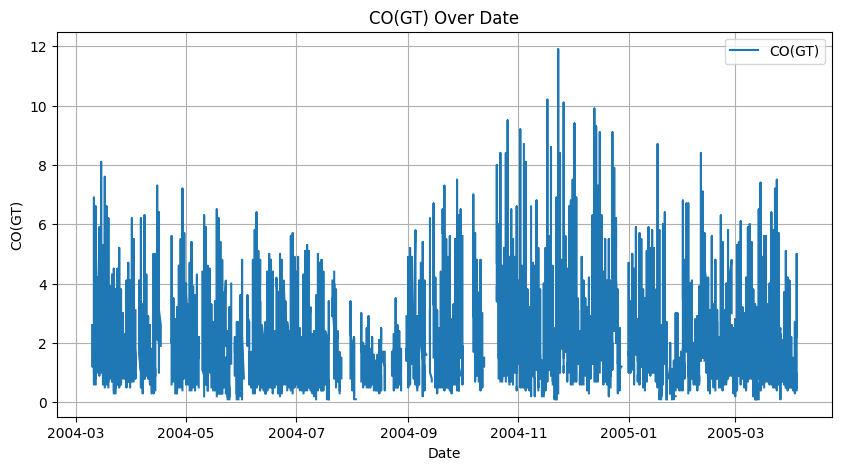

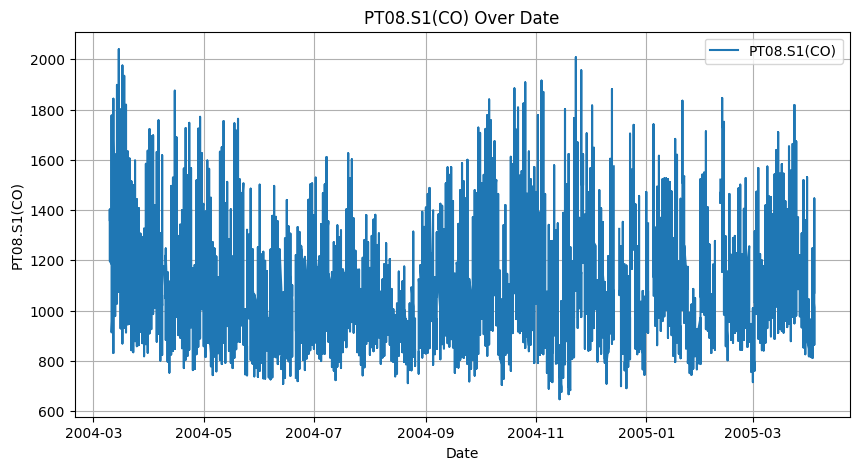

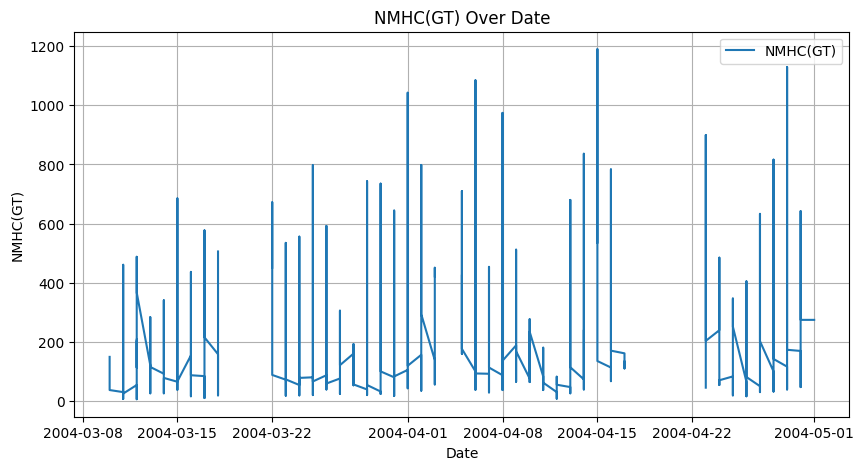

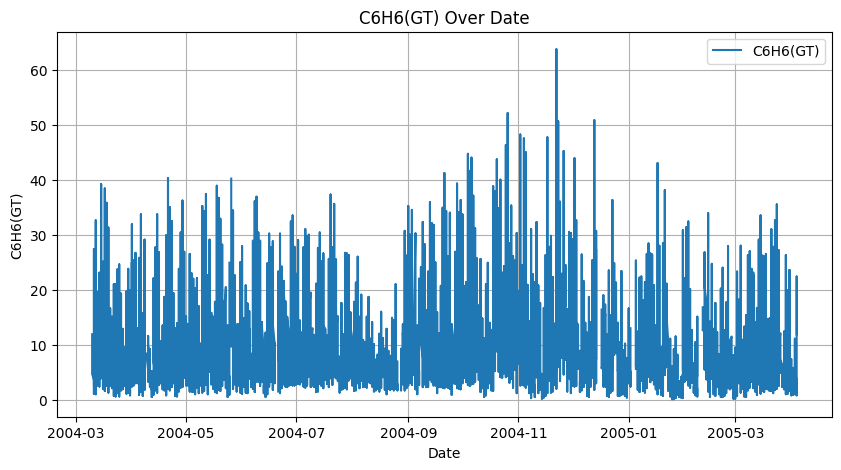

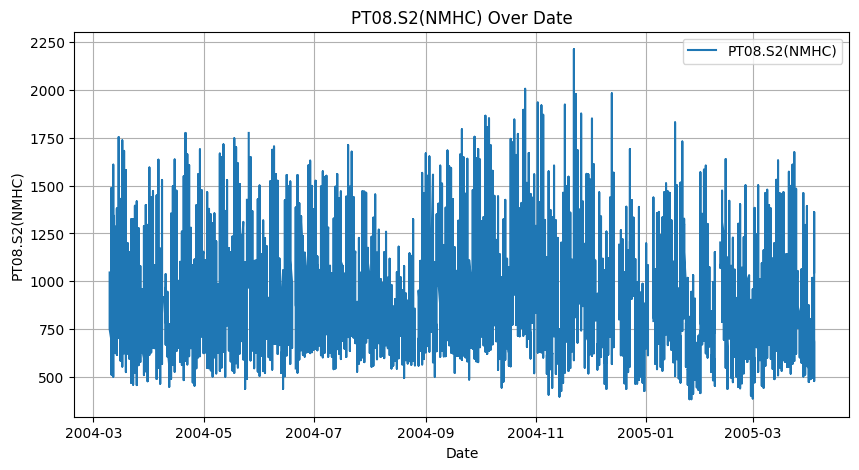

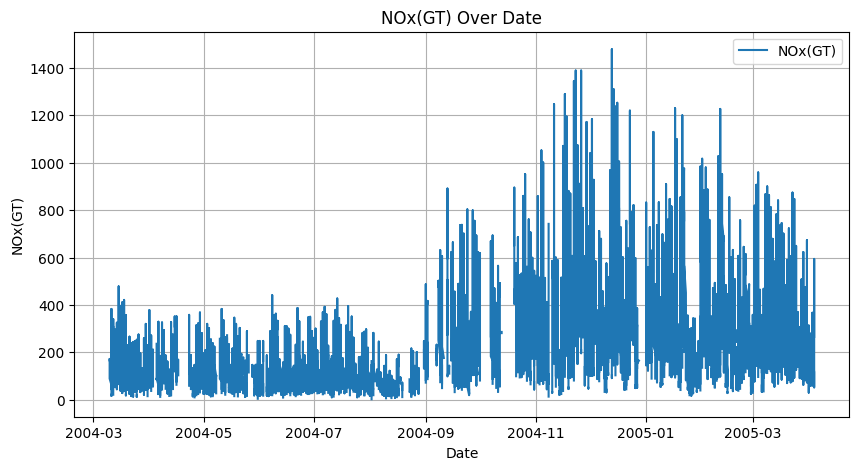

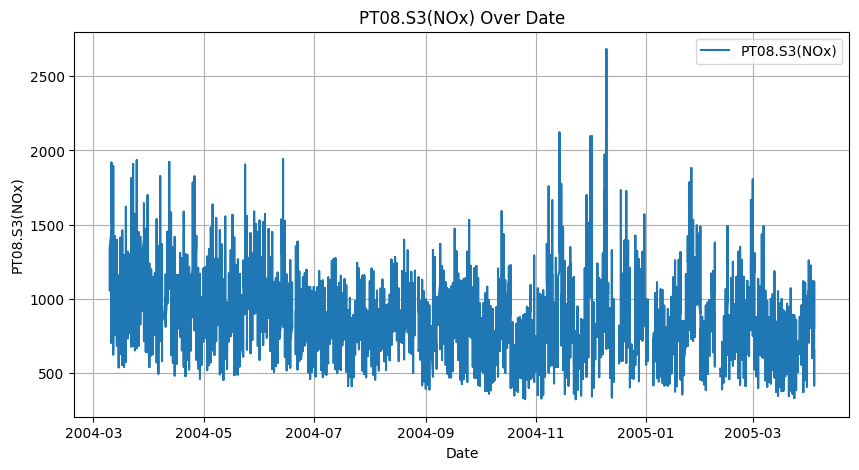

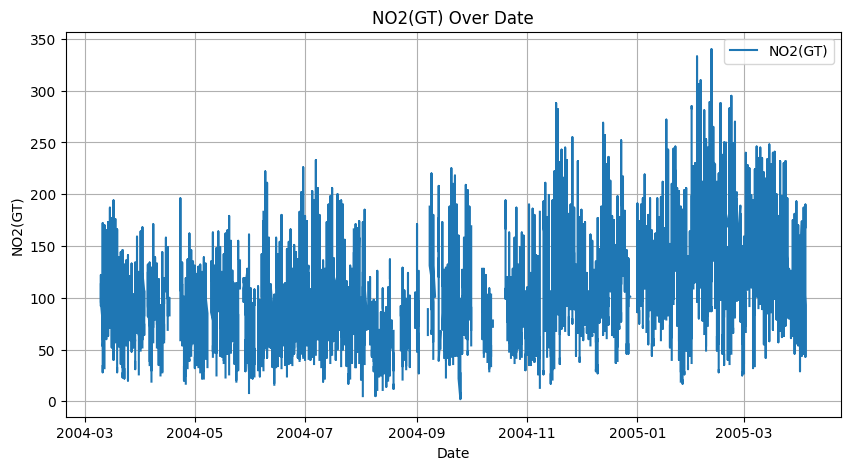

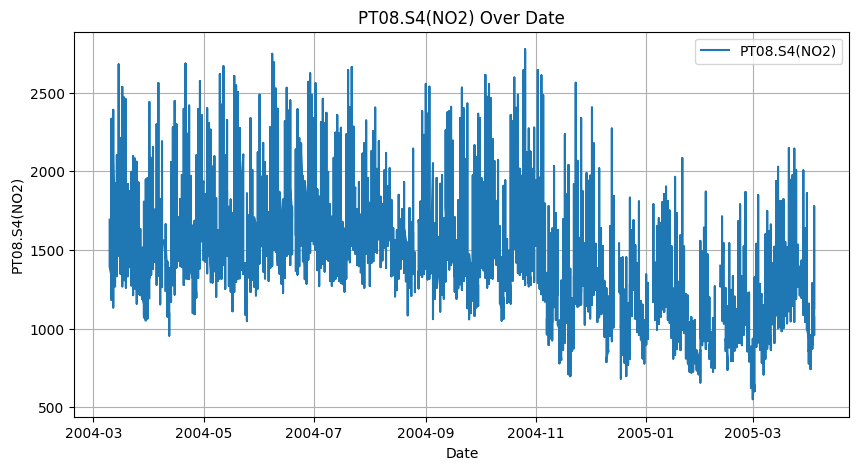

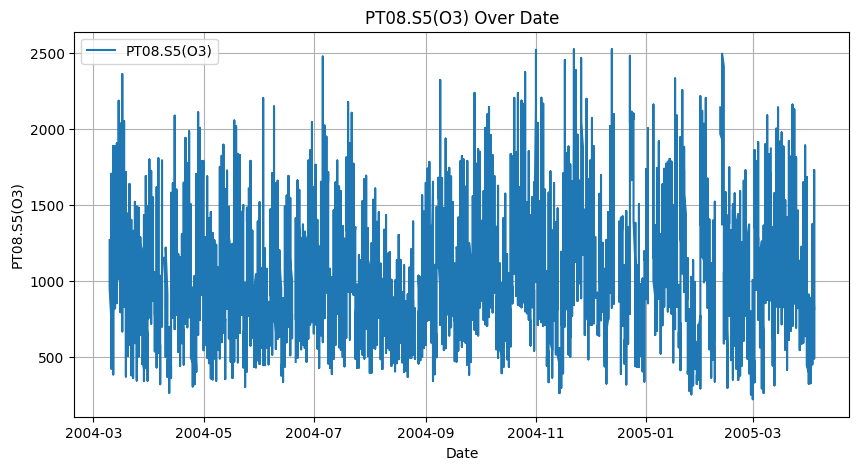

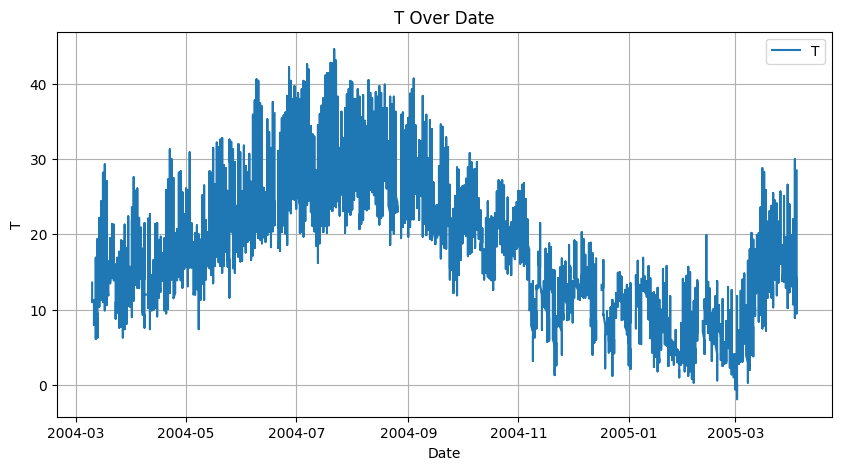

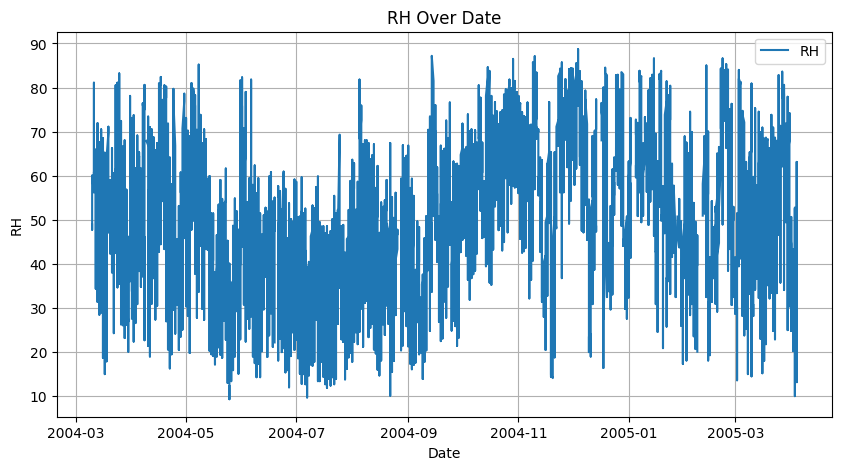

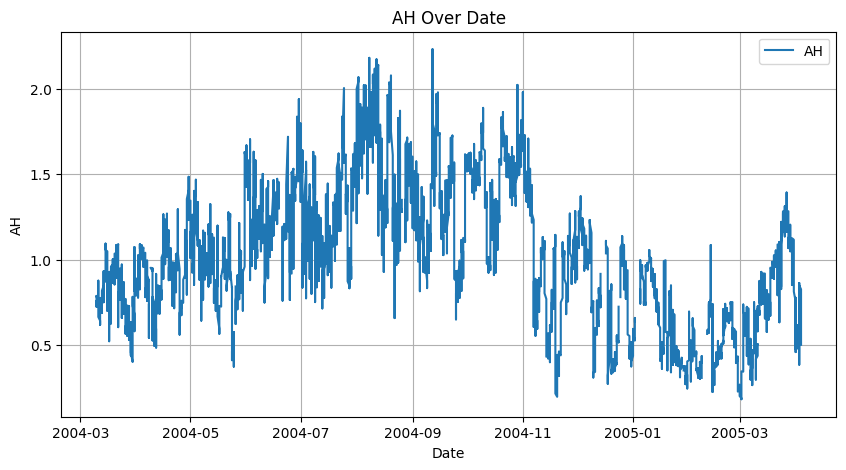

In [ ]:
for column in data.columns:
    if column != 'Date' and column != "Time":
        plt.figure(figsize=(10, 5))
        plt.plot(data['Date'], data[column], linestyle='-', label=column)
        plt.title(f'{column} Over Date')
        plt.xlabel('Date')
        plt.ylabel(column)
        plt.legend()
        plt.grid()
        plt.show()


Can be seen that feature PT08.S4(NO2) had decreasing trend at the end of recording period. Also values of feature NO2(GT) had increasing trend at the end of registering period. Feature PT08.S3(NOx) had decreasing tendency over period of registering. Feature NOx(GT) started taking high values after around the middle point of registering period. But overall , there is almost no useful infromation from dependency of sensor values over Date feature. So, during regression we wil not use Date feature.  
Also we see natural pattern in dependency of tempreture over all time period. It should be higher in summer and lower in winter, that is exactly what we notice from plot. The same behavioural pattern has AH feature, which represnts absolute humidity.

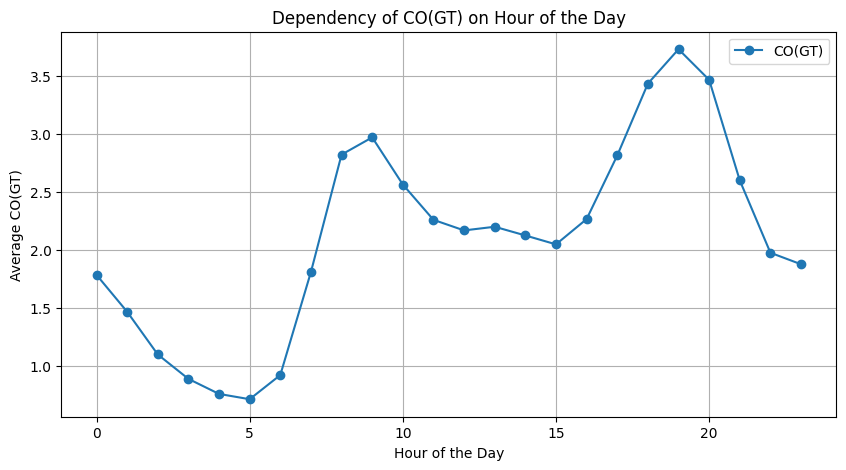

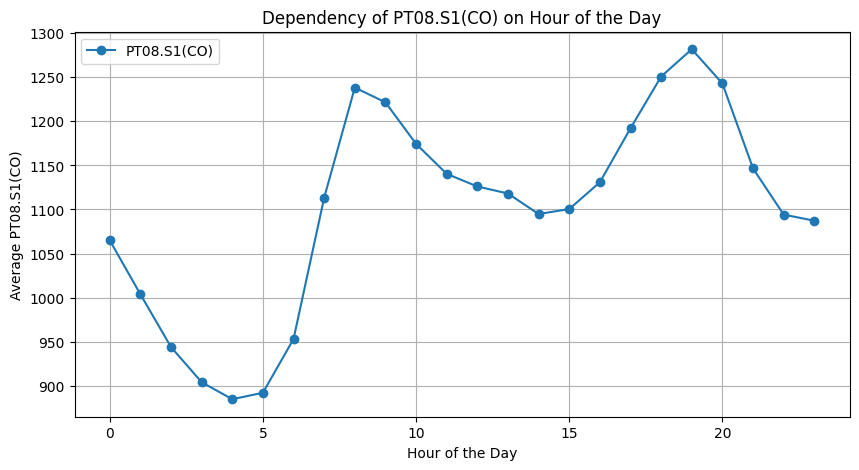

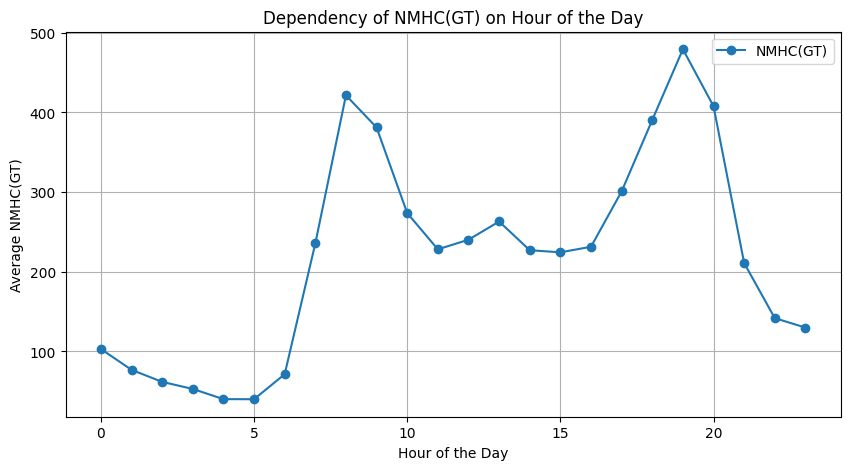

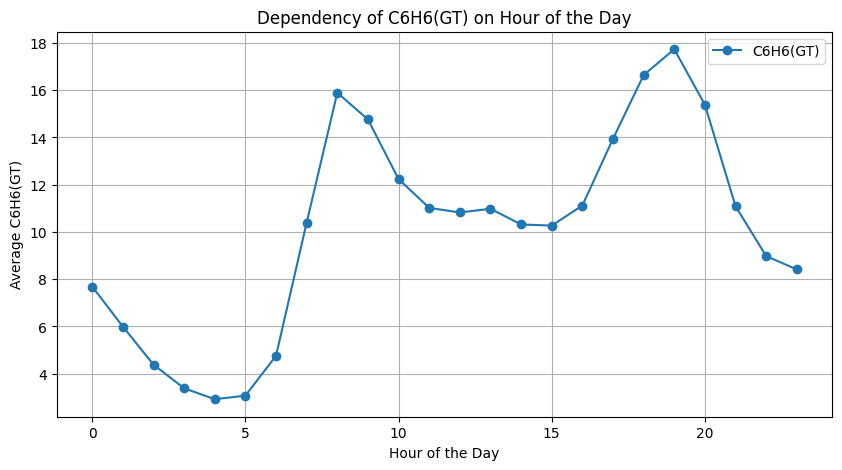

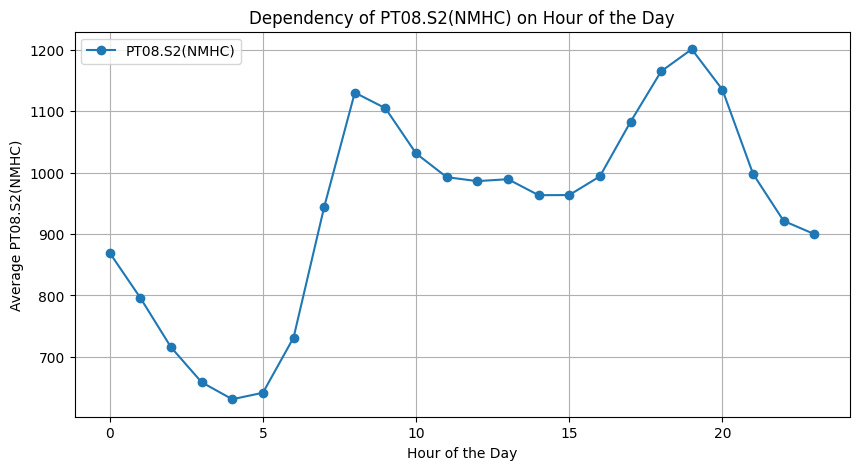

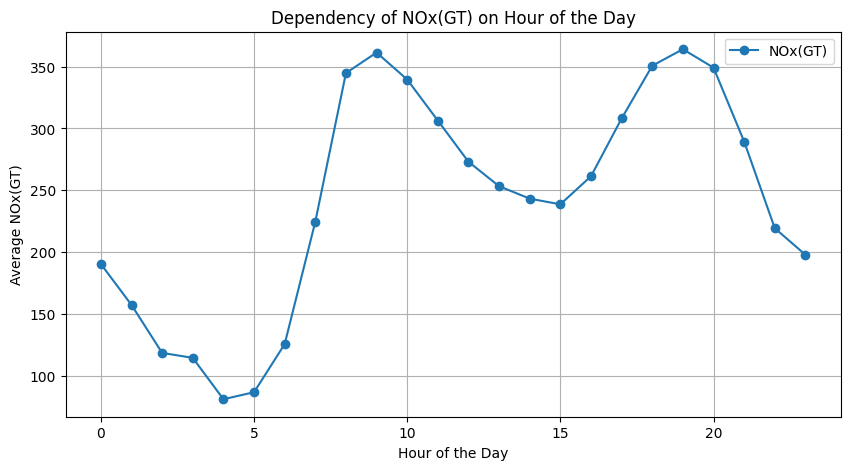

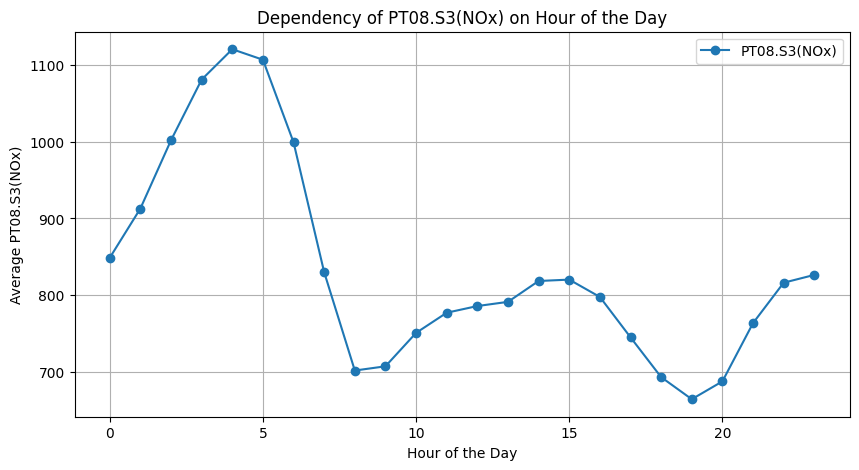

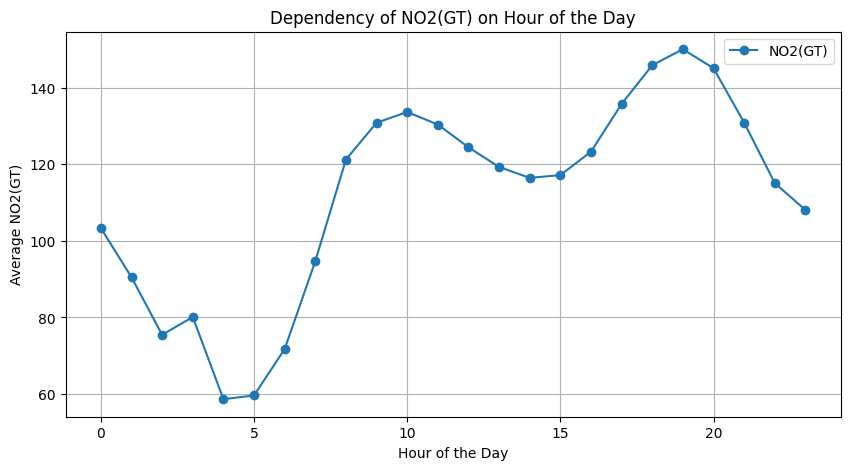

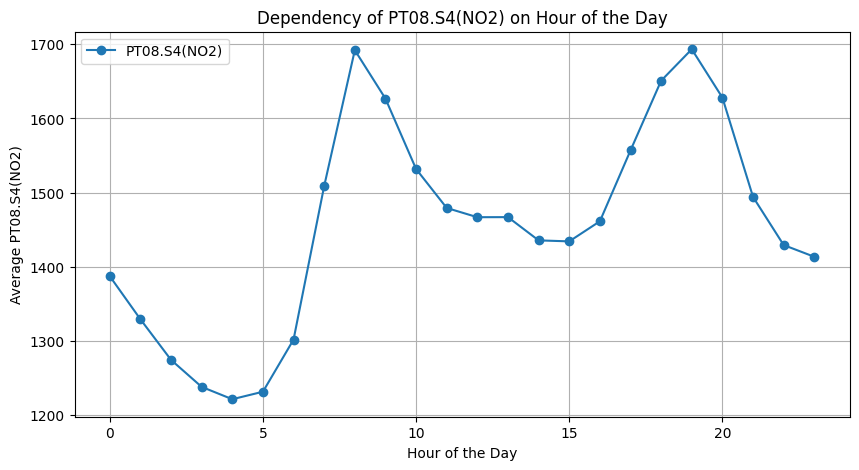

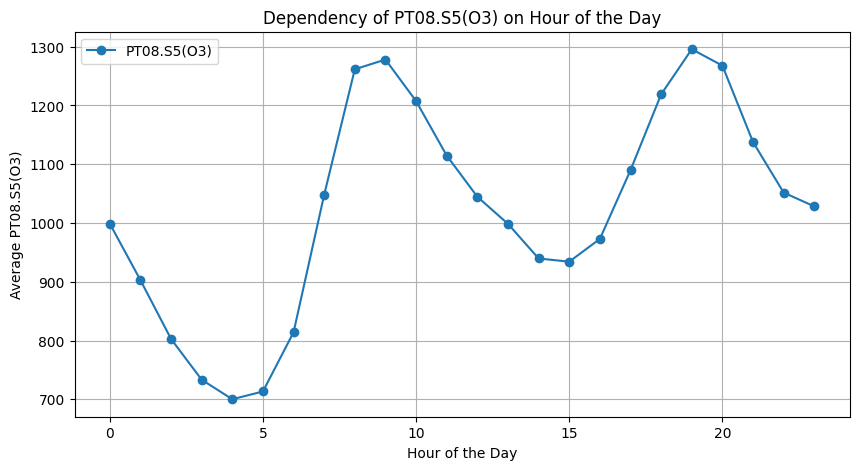

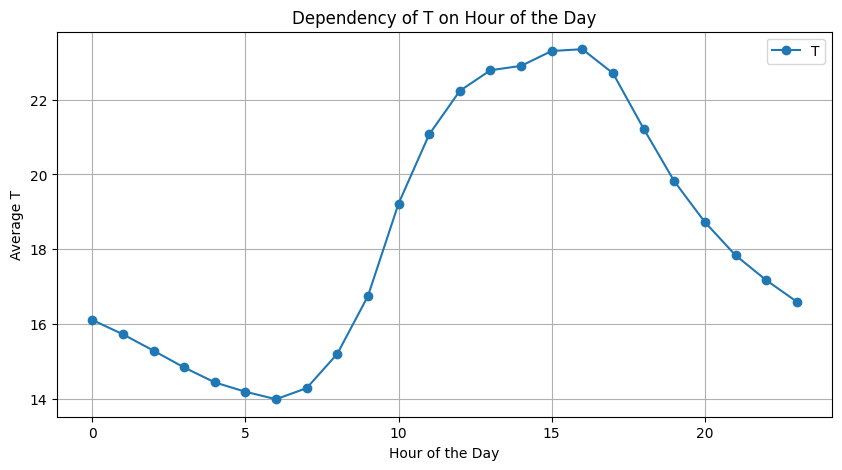

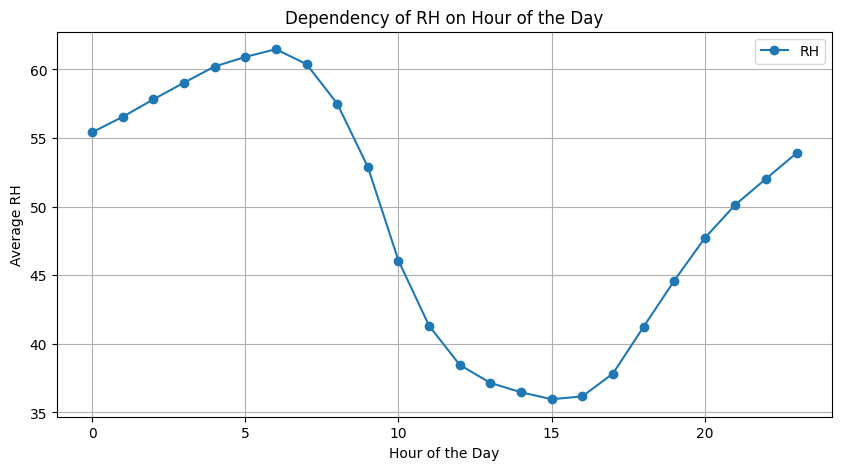

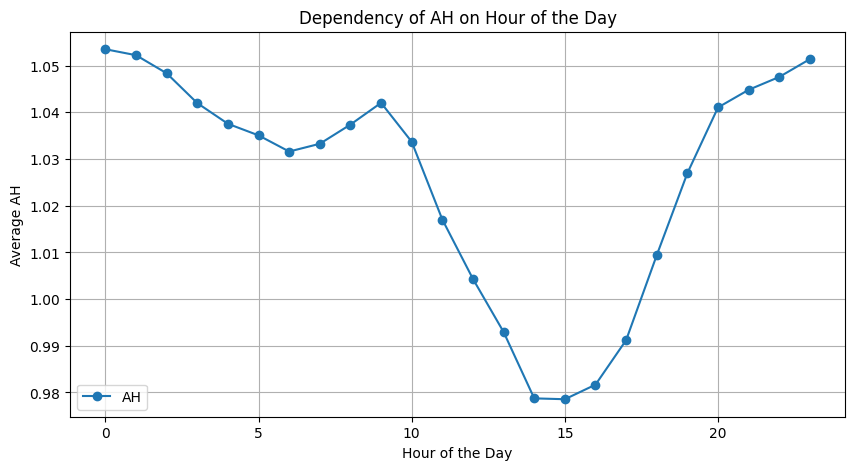

In [ ]:
hours = pd.to_datetime(data['Time'], format='%H:%M:%S').dt.hour

for feature in numeric_columns:
    hourly_means = data.groupby(hours)[feature].mean()
    plt.figure(figsize=(10, 5))
    plt.plot(hourly_means.index, hourly_means.values, marker='o', linestyle='-', label=feature)
    plt.title(f'Dependency of {feature} on Hour of the Day')
    plt.xlabel('Hour of the Day')
    plt.ylabel(f'Average {feature}')
    plt.grid()
    plt.legend()
    plt.show()

On above plots we can see the dependency of each sensor average value over each hour of the day. For example , average Temprature clearly follows expectations, to get lower at night and higher at the day time.  

The same behaviour pattern during 24 hours show features: PT08.S5(O3), PT08.S4(NO2), NO2(GT), NOx(GT), PT08.S2(NMHC), C6H6(GT), NMHC(GT), PT08.S1(CO), CO(GT). That is also natural, as from graphics we see that average value of each of those listed features increases at the morning and just before the evening, which corresponds to start of the working day and end of it. It is expected that during those periods of time amount of emissions in the air is going to increase.

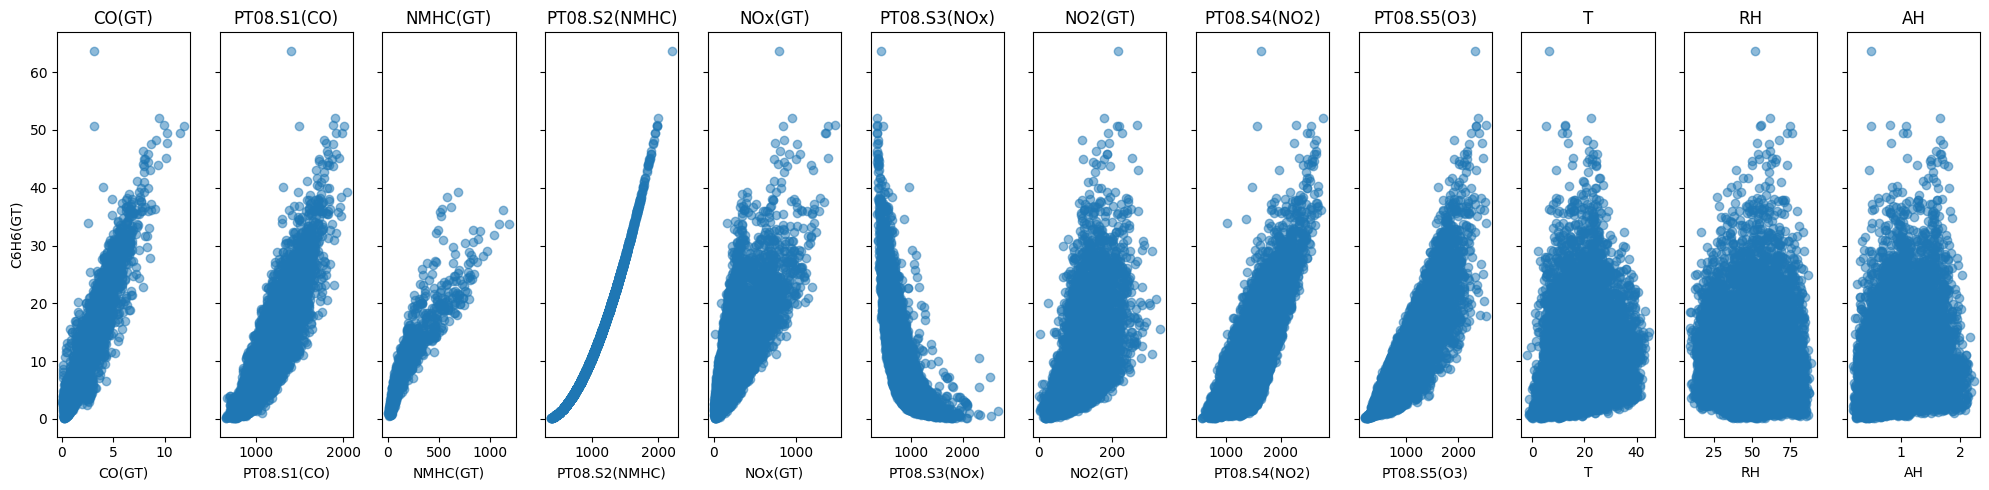

In [ ]:
features_to_plot = data.select_dtypes(include='number').columns.drop('C6H6(GT)', 'Time')
fig, axes = plt.subplots(1, len(features_to_plot), figsize=(20, 5), sharey=True)

for i, feature in enumerate(features_to_plot):
    axes[i].scatter(data[feature], data['C6H6(GT)'], alpha=0.5)
    axes[i].set_title(feature)
    axes[i].set_xlabel(feature)
    if i == 0:
        axes[i].set_ylabel('C6H6(GT)')

plt.tight_layout()
plt.show()

We see that there are clear dependencies between independent features and dependent target variable, only features T, RH, AH do not show any strong dependency with target variable(also probably NO2(GT) does not have relationship with target, but we will investigate in next section).

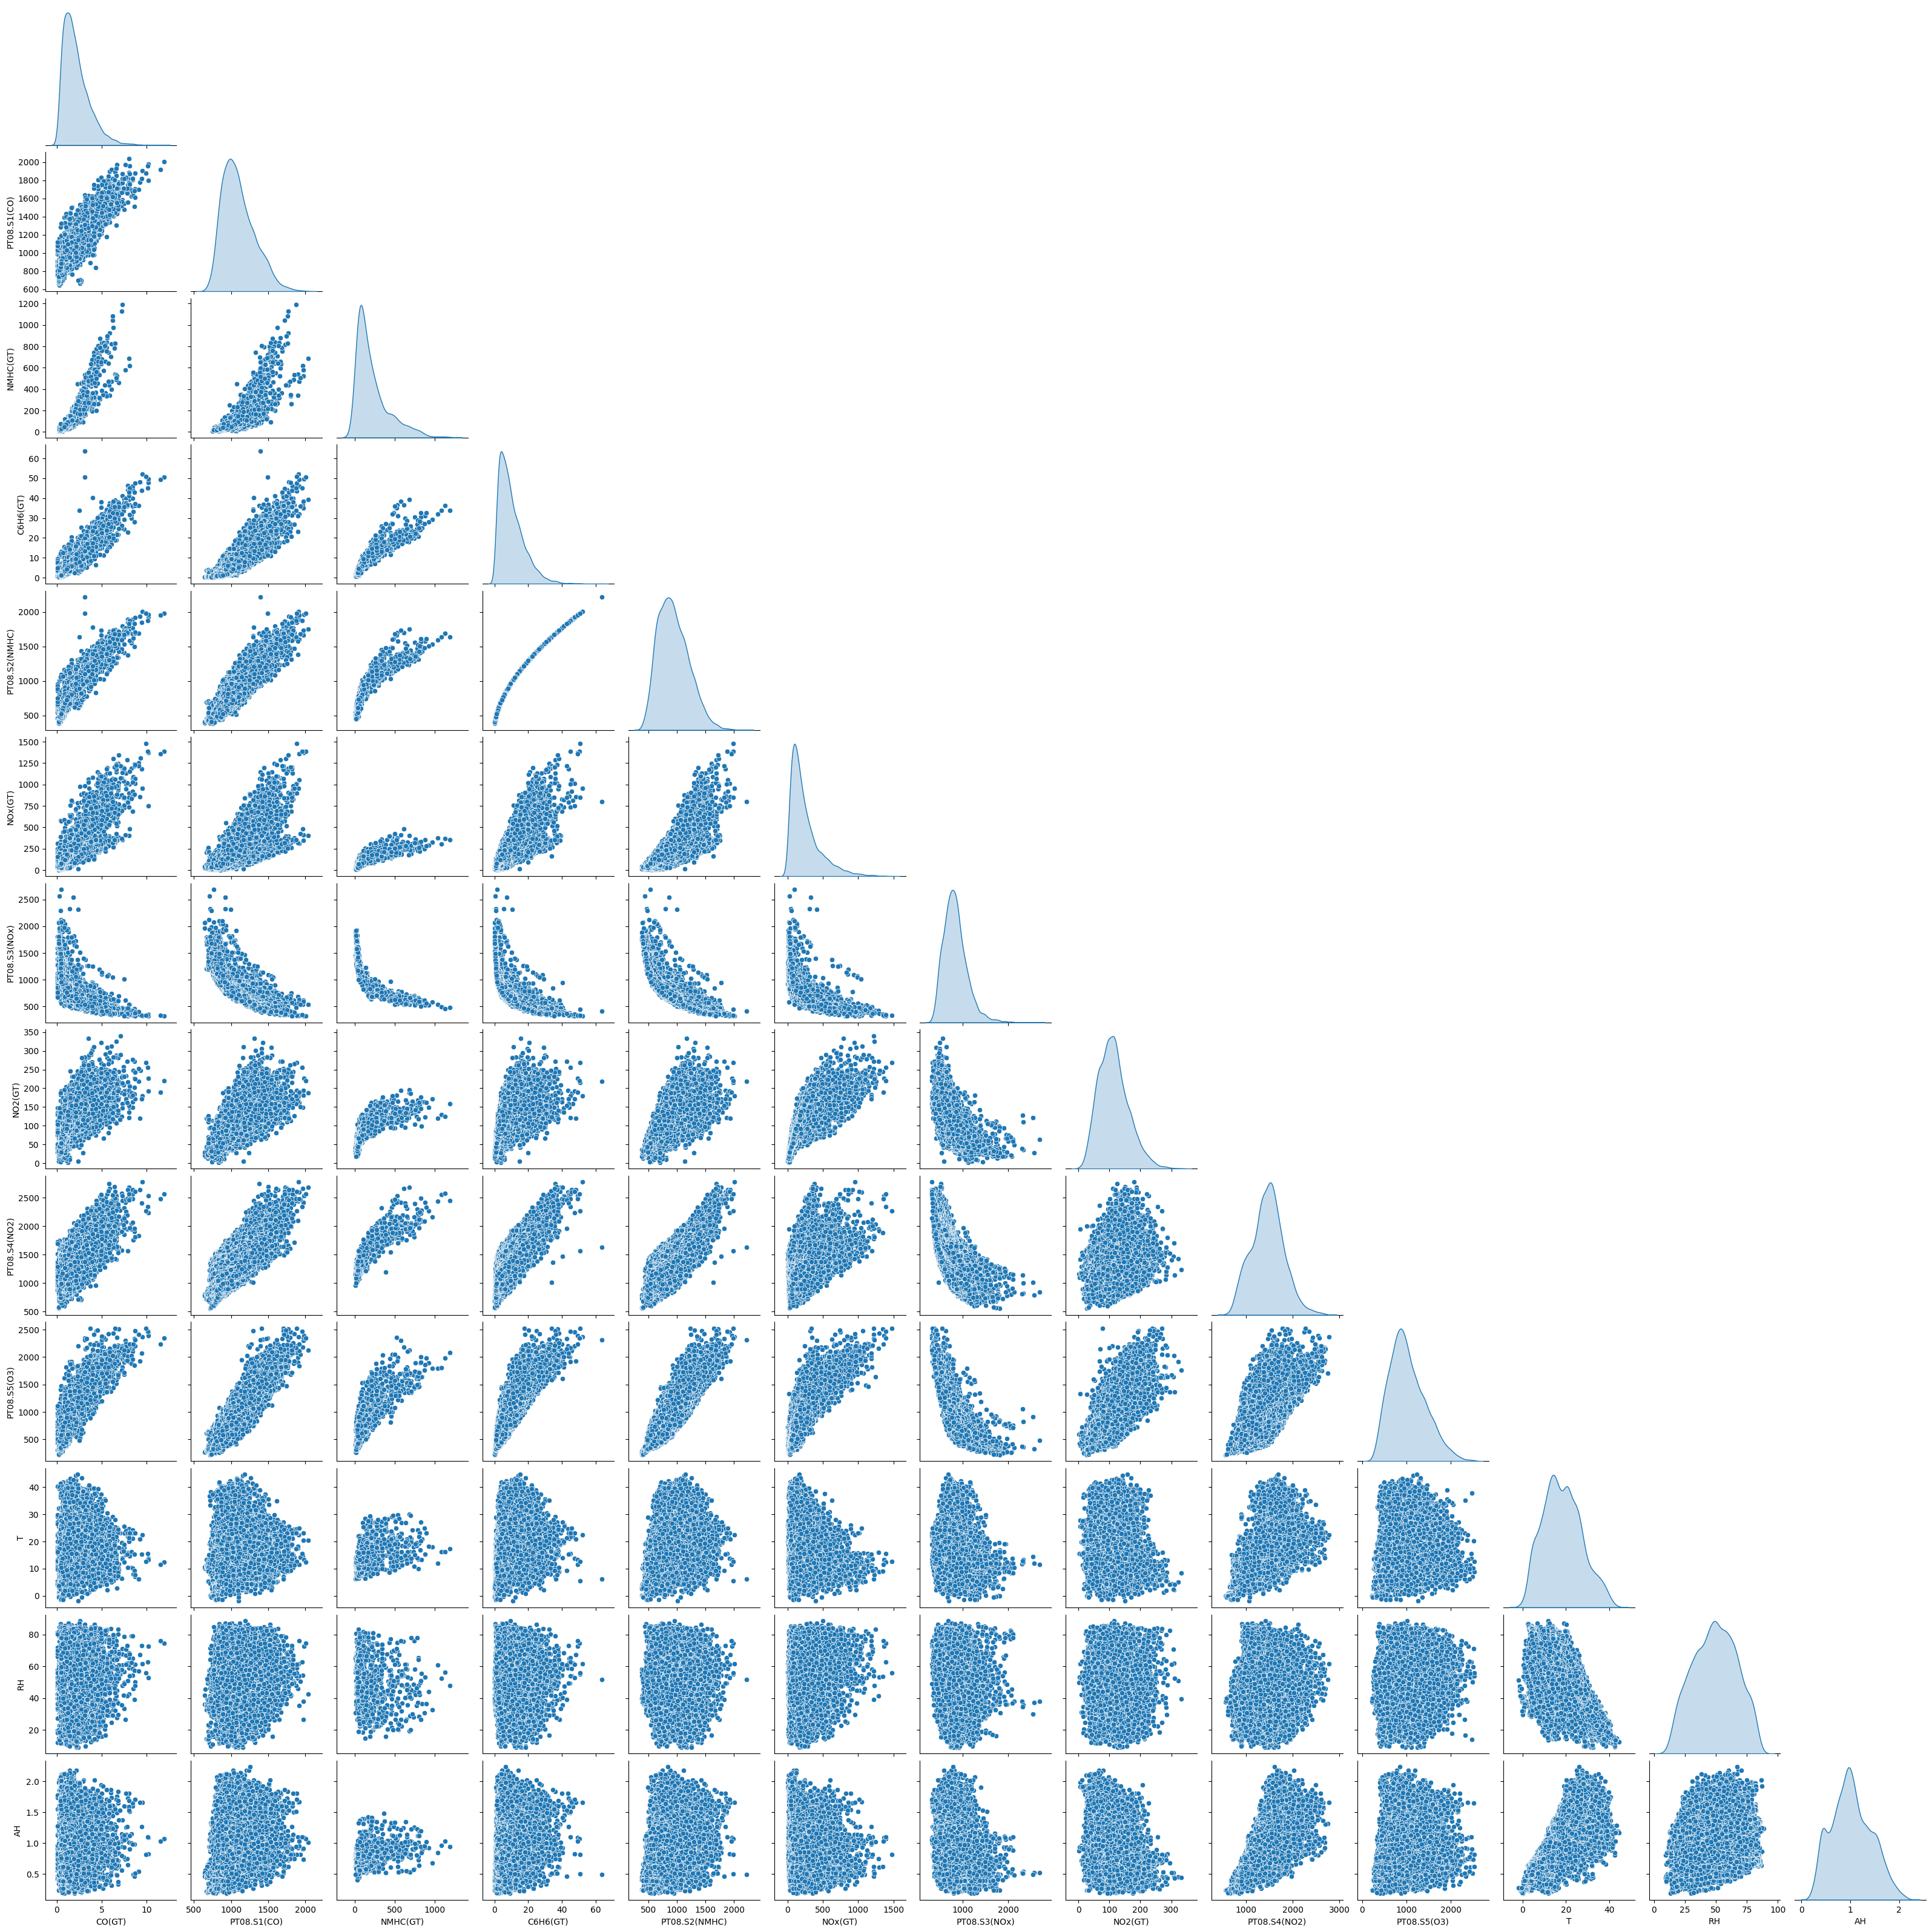

In [ ]:
sns.pairplot(data.select_dtypes(include='number'), diag_kind='kde', corner=True)
plt.show()

The functional relationship is seen between target variable(C6H6(GT)) and variables: PT08.S5(O3) , PT08.S4(NO2), PT08.S3(NOx), NOx(GT), PT08.S2(NMHC), CO(GT), PT08.S1(CO), NMHC(GT). Now, we see that not every relationship is similiar to linear, so for mentioned before independent variables we are going to apply tranformations, in order to linearize the relationship between them and our target. There is no seen clear relationship between target variable and NO2(GT), the same goes for variables T, PH, AH. We are not going to use those last variables for regression.

We also see that there exists relationship between independent variables, which could lead to unwanted multicolinearity of explaining features.

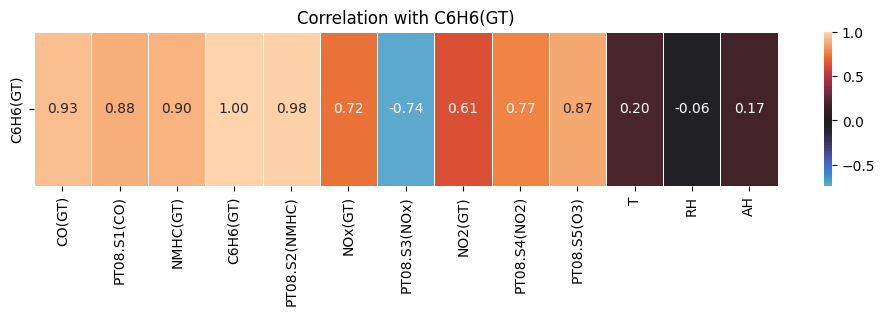

In [ ]:
corr_with_target = data.select_dtypes(include='number').corr()[['C6H6(GT)']].T

plt.figure(figsize=(12, 2))
sns.heatmap(corr_with_target, annot=True, fmt=".2f", center=0, linewidths=0.5)
plt.title('Correlation with C6H6(GT)')
plt.show()

Conclusions in paragraph above are backed by this corellation matrix. We see that target variable is highly linearly correlated with PT08.S2(NMHC), CO(GT), NMHC(GT), PT08.S1(CO), PT08.S5(O3).

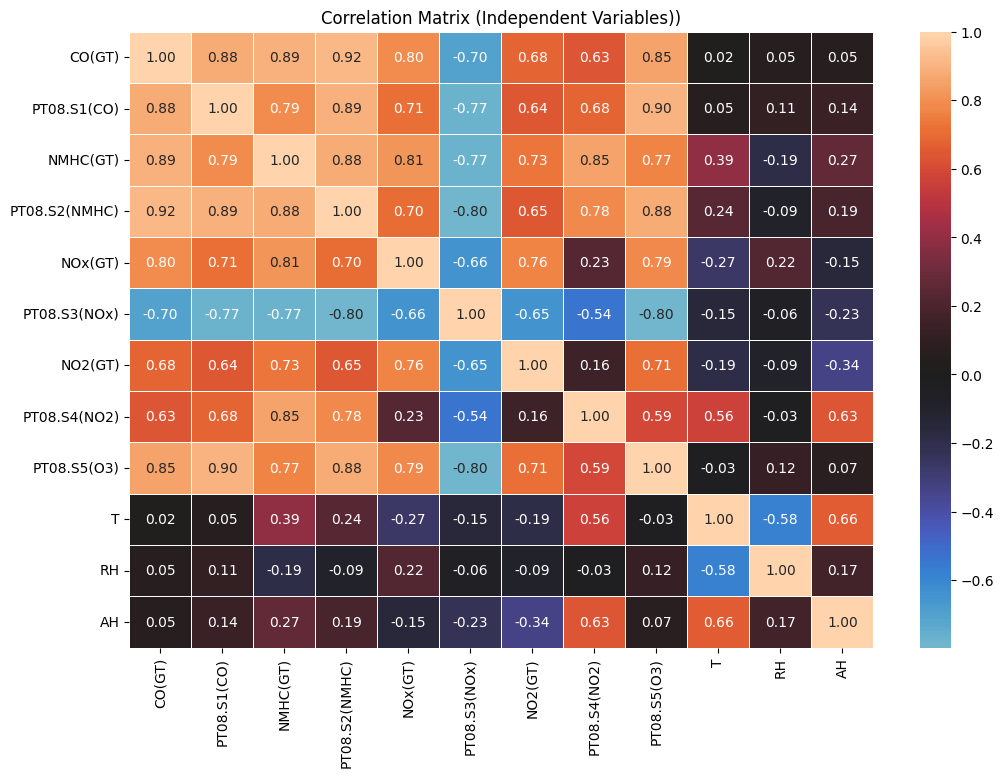

In [ ]:
corr_matrix = data.select_dtypes(include='number').drop(columns=['C6H6(GT)']).corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', center=0, linewidths=0.5)
plt.title('Correlation Matrix (Independent Variables))')
plt.show()

Target variable is highly coorelated with all independent variables (except features T, RH, AH, NO2(GT))  
Can be seen that features T, RH, AH are not strongly correlated with other features. We will not use those features in regression model, as there is no seen pattern between them and target varibale (based on pair plots and correlation coefficients).  
Also we see that other independent features (apart from T, RH, AH) are correlated, we will have to do deal with this multicolinearity.

**Data preparation**  
**Missing values**  
We will drop from dataset feature: , as 90 % of its values are missing. Also , for all instances that have all empty entries for each sensor feature we will impute missing values with according values from previous day, same hour.

In [ ]:
data = data.drop(columns=['NMHC(GT)'])

In [ ]:
def fill_missing_with_previous_day(data):
    data['Hour'] = pd.to_datetime(data['Time'], format='%H:%M:%S').dt.hour

    for col in data.columns:
        if col not in ['Date', 'Time', 'Hour']:
            data[col] = data.groupby('Hour')[col].fillna(method='ffill')

    data = data.drop(columns=['Hour'])
    return data
data = fill_missing_with_previous_day(data)

<ipython-input-20-26459a8c9ae9>:6: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  data[col] = data.groupby('Hour')[col].fillna(method='ffill')
<ipython-input-20-26459a8c9ae9>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[col] = data.groupby('Hour')[col].fillna(method='ffill')


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9357 non-null   datetime64[ns]
 1   Time           9357 non-null   object        
 2   CO(GT)         9343 non-null   float64       
 3   PT08.S1(CO)    9357 non-null   float64       
 4   C6H6(GT)       9357 non-null   float64       
 5   PT08.S2(NMHC)  9357 non-null   float64       
 6   NOx(GT)        9095 non-null   float64       
 7   PT08.S3(NOx)   9357 non-null   float64       
 8   NO2(GT)        9095 non-null   float64       
 9   PT08.S4(NO2)   9357 non-null   float64       
 10  PT08.S5(O3)    9357 non-null   float64       
 11  T              9357 non-null   float64       
 12  RH             9357 non-null   float64       
 13  AH             9357 non-null   float64       
dtypes: datetime64[ns](1), float64(12), object(1)
memory usage: 1023.5+ KB


Also it happen there was not a specific value registered for some feature at speicific hour at the very beginning, so there will no be performed any filling for such values, and they will remain Nans. So we need to complete filling with another strategy, the missing value will be filled with value of the previous hour within same feature.

In [ ]:
def fill_missing_with_previous_hour(data):
    data['Hour'] = pd.to_datetime(data['Time'], format='%H:%M:%S').dt.hour
    for col in data.columns:
        if col not in ['Date', 'Time', 'Hour']:
            data[col] = data.groupby('Date')[col].fillna(method='ffill')
    data = data.drop(columns=['Hour'])
    return data

data = fill_missing_with_previous_hour(data)

<ipython-input-22-33484eb1fa4a>:5: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  data[col] = data.groupby('Date')[col].fillna(method='ffill')
<ipython-input-22-33484eb1fa4a>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[col] = data.groupby('Date')[col].fillna(method='ffill')


Conclusion, such strategies will keep structure , time dependencies of sensor values. It would not be appropriate to use too generalized filling with median or even mean, as such strategies would introduce new unnatural patterns in data , semi outliers.


**Feature engineering**

In [ ]:
def transform_dataframe(data, transformations, target_column):
    transformed_data = pd.DataFrame()
    for feature, transform_func in transformations.items():
        transformed_data[feature] = transform_func(data[feature])
    transformed_data[target_column] = data[target_column]
    return transformed_data

transformations = {
    'CO(GT)': lambda x: x**1/4,
    'PT08.S1(CO)': lambda x: x**2,
    'PT08.S3(NOx)': lambda x: (x) ** -2,
    'NOx(GT)': lambda x: (x**1/2)*np.log(x),
    'PT08.S2(NMHC)': lambda x: x**2,
    'PT08.S4(NO2)': lambda x: x**2,
    'PT08.S5(O3)': lambda x: x**2
}

target_column = 'C6H6(GT)'
transformed_data = transform_dataframe(data, transformations, target_column)
transformed_data.head()

CO(GT)  PT08.S1(CO)  PT08.S3(NOx)     NOx(GT)  PT08.S2(NMHC)  PT08.S4(NO2)  \
0    0.65    1849600.0  8.967516e-07  424.294986      1094116.0     2862864.0   
1    0.50    1669264.0  7.255441e-07  238.688543       912025.0     2430481.0   
2    0.55    1965604.0  7.694675e-07  319.325425       881721.0     2418025.0   
3    0.55    1893376.0  8.385997e-07  442.684525       898704.0     2509056.0   
4    0.40    1617984.0  6.886934e-07  319.325425       698896.0     2220100.0   

   PT08.S5(O3)  C6H6(GT)  
0    1607824.0      11.9  
1     944784.0       9.4  
2    1153476.0       9.0  
3    1447209.0       9.2  
4    1232100.0       6.5

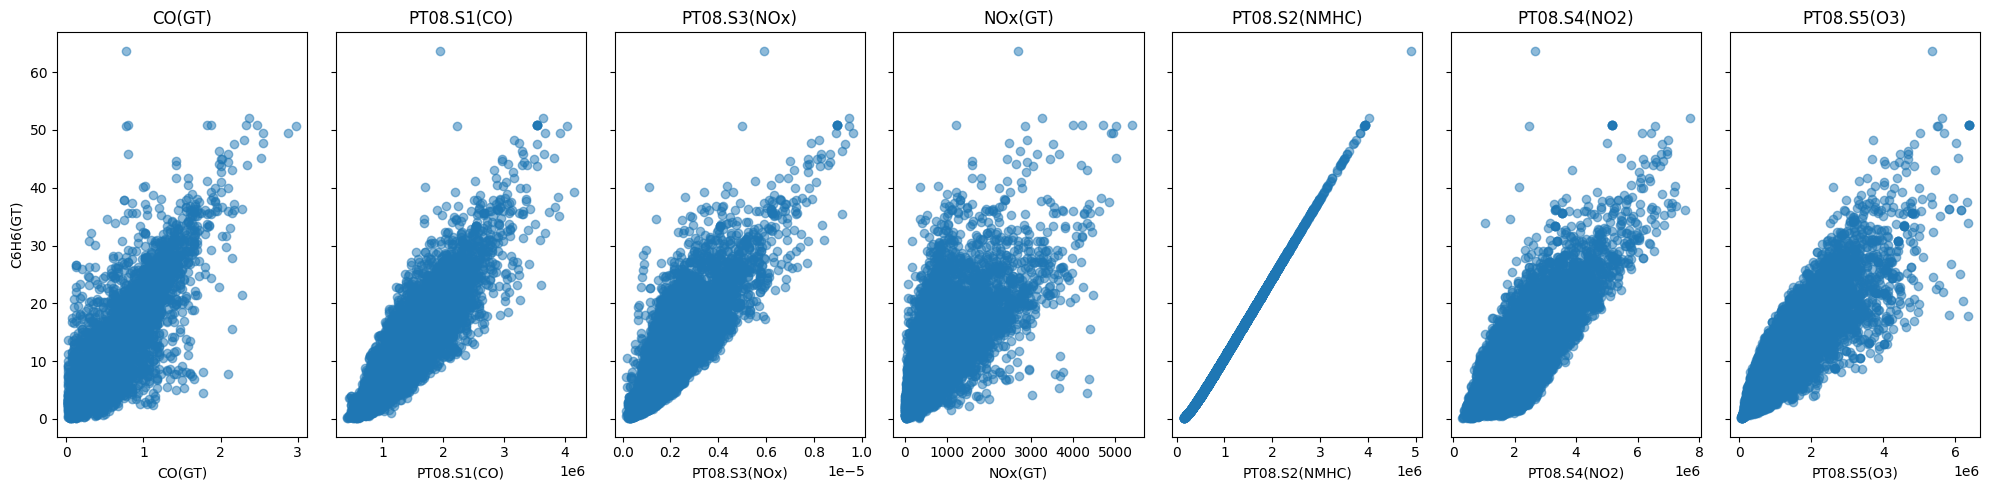

In [ ]:
features_to_plot = transformed_data.select_dtypes(include='number').columns.drop('C6H6(GT)')
fig, axes = plt.subplots(1, len(features_to_plot), figsize=(20, 5), sharey=True)

for i, feature in enumerate(features_to_plot):
    axes[i].scatter(transformed_data[feature], transformed_data['C6H6(GT)'], alpha=0.5)
    axes[i].set_title(feature)
    axes[i].set_xlabel(feature)
    if i == 0:
        axes[i].set_ylabel('C6H6(GT)')

plt.tight_layout()
plt.show()

Here were appplied basic tranfomations on features , so to make relationship between independent variables as much linear as possible. Transformations were picked on basis of initial relationship between independend variables and dependent. We see perfect linear dependency between feature PT08.S2(NMHC). Also there is rather good linear like relationship between target variable (C6H6(GT)) and transformed independent varibales: CO(GT), PT08.S1(CO), PT08.S3(NOx), PT08.S4(NO2), PT08.S5(O3), NOx(GT).

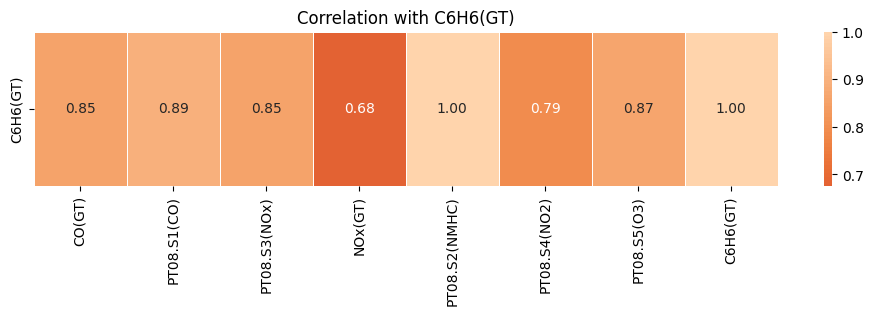

In [ ]:
corr_with_target = transformed_data.select_dtypes(include='number').corr()[['C6H6(GT)']].T

plt.figure(figsize=(12, 2))
sns.heatmap(corr_with_target, annot=True, fmt=".2f", center=0, linewidths=0.5)
plt.title('Correlation with C6H6(GT)')
plt.show()

Correlation matrix backs derived insights about relationship between target variable and non linearly transformed independent features.

**Standardizing independent features**

In [ ]:
independent_features = transformed_data.drop(columns=['C6H6(GT)'])
transformed_data[independent_features.columns] = (independent_features - independent_features.mean()) / independent_features.std()

In [ ]:
transformed_data.head()

CO(GT)  PT08.S1(CO)  PT08.S3(NOx)   NOx(GT)  PT08.S2(NMHC)  PT08.S4(NO2)  \
0  0.356899     1.146632     -0.809792 -0.370903       0.254155      0.606751   
1 -0.060966     0.798018     -0.951912 -0.636990      -0.074789      0.194243   
2  0.078323     1.370883     -0.915451 -0.521388      -0.129533      0.182359   
3  0.078323     1.231256     -0.858064 -0.344539      -0.098853      0.269206   
4 -0.339542     0.698887     -0.982501 -0.521388      -0.459803     -0.006468   

   PT08.S5(O3)  C6H6(GT)  
0     0.413761      11.9  
1    -0.280946       9.4  
2    -0.062287       9.0  
3     0.245475       9.2  
4     0.020092       6.5

We will center and scale independent features to mitigate artificial multicollinearity that appears after feature transformations. Was performed standardization. Also it was done so to correctly interpret coefficient values of independent variables after linear model fit

---



In [ ]:
to_drop = ['PT08.S1(CO)', 'PT08.S3(NOx)', 'PT08.S5(O3)', 'PT08.S4(NO2)']
transformed_data = transformed_data.drop(columns=to_drop)
transformed_data.head()

CO(GT)   NOx(GT)  PT08.S2(NMHC)  C6H6(GT)
0  0.356899 -0.370903       0.254155      11.9
1 -0.060966 -0.636990      -0.074789       9.4
2  0.078323 -0.521388      -0.129533       9.0
3  0.078323 -0.344539      -0.098853       9.2
4 -0.339542 -0.521388      -0.459803       6.5

It was decided to drop some features , as high multicollinearity exists between independent variables. That multicolinearity will blur our understanding of feature importance after training a model. Were left features with highest correlation to target, and which were not interdependent.

In [ ]:
def calculate_vif(features):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = features.columns
    vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    return vif_data

X = transformed_data.drop(columns=['C6H6(GT)'])
vif_results = calculate_vif(X)
vif_results

Feature       VIF
0         CO(GT)  5.063518
1        NOx(GT)  2.536270
2  PT08.S2(NMHC)  3.683656

VIFs are telling us that our independent variables are not multicorrelated very much.  
Conlcusion. After all operations on features: transformations, standardizing, dropping redundant features, we are left with few that could be used for regression. Those features do not inroduce high multicollinearity, though still are highly correlated with target feature.

**Model fitting 1**

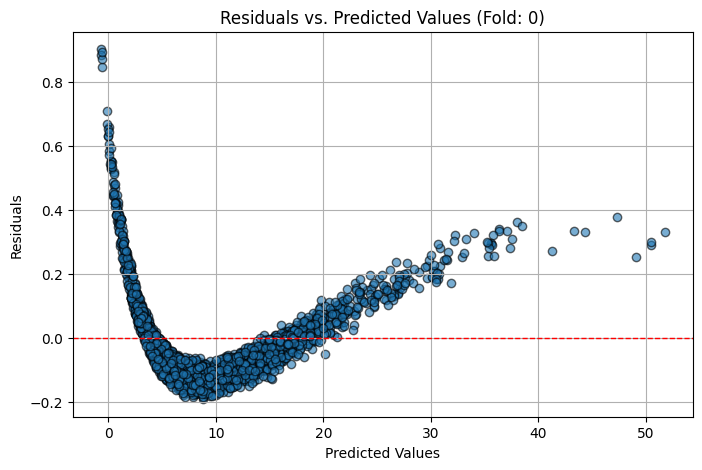

                            OLS Regression Results                            
Dep. Variable:               C6H6(GT)   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.789e+06
Date:                Sun, 24 Nov 2024   Prob (F-statistic):               0.00
Time:                        12:35:22   Log-Likelihood:                 3326.8
No. Observations:                7485   AIC:                            -6646.
Df Residuals:                    7481   BIC:                            -6618.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            10.0869      0.002   5623.332

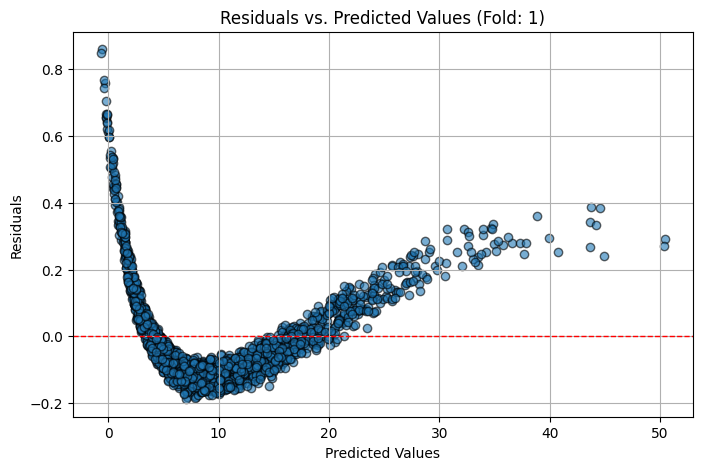

                            OLS Regression Results                            
Dep. Variable:               C6H6(GT)   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.765e+06
Date:                Sun, 24 Nov 2024   Prob (F-statistic):               0.00
Time:                        12:35:22   Log-Likelihood:                 3329.0
No. Observations:                7485   AIC:                            -6650.
Df Residuals:                    7481   BIC:                            -6622.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            10.0862      0.002   5624.536

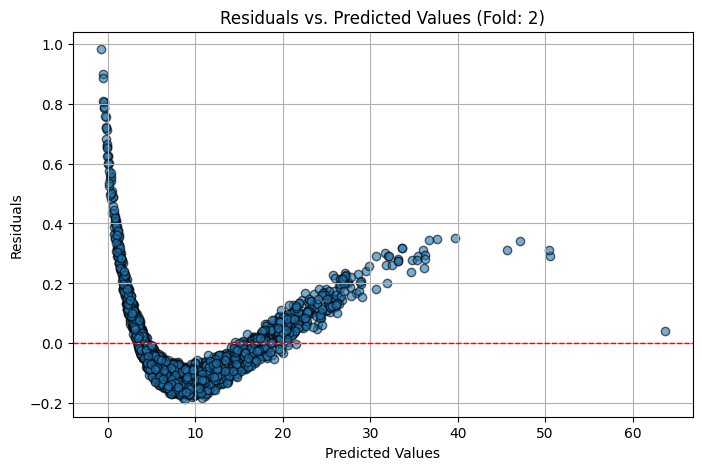

                            OLS Regression Results                            
Dep. Variable:               C6H6(GT)   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.901e+06
Date:                Sun, 24 Nov 2024   Prob (F-statistic):               0.00
Time:                        12:35:22   Log-Likelihood:                 3366.1
No. Observations:                7486   AIC:                            -6724.
Df Residuals:                    7482   BIC:                            -6696.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            10.0858      0.002   5652.338

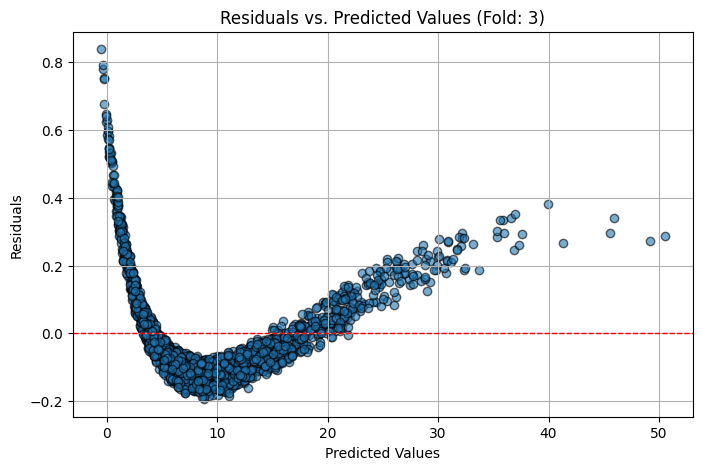

                            OLS Regression Results                            
Dep. Variable:               C6H6(GT)   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.861e+06
Date:                Sun, 24 Nov 2024   Prob (F-statistic):               0.00
Time:                        12:35:23   Log-Likelihood:                 3310.3
No. Observations:                7486   AIC:                            -6613.
Df Residuals:                    7482   BIC:                            -6585.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            10.0869      0.002   5610.878

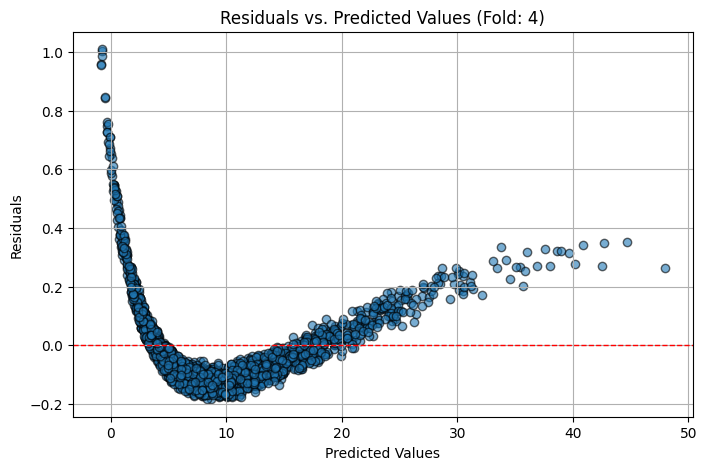

                            OLS Regression Results                            
Dep. Variable:               C6H6(GT)   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.055e+06
Date:                Sun, 24 Nov 2024   Prob (F-statistic):               0.00
Time:                        12:35:23   Log-Likelihood:                 3413.5
No. Observations:                7486   AIC:                            -6819.
Df Residuals:                    7482   BIC:                            -6791.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            10.0865      0.002   5688.625

In [ ]:
X = transformed_data.drop(columns=['C6H6(GT)'])
y = transformed_data['C6H6(GT)']

X = sm.add_constant(X)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
r2_list = []
adj_r2_list = []

count = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = sm.OLS(y_train, X_train).fit()

    y_pred = model.predict(X_test)

    residuals = y_test - y_pred

    mae = mean_absolute_error(y_test, y_pred)
    mae_list.append(mae)

    r2 = model.rsquared
    adj_r2 = model.rsquared_adj
    r2_list.append(r2)
    adj_r2_list.append(adj_r2)

    plt.figure(figsize=(8, 5))
    plt.scatter(y_pred, residuals, alpha=0.6, edgecolor='k')
    plt.axhline(0, color='r', linestyle='--', linewidth=1)
    plt.title(f"Residuals vs. Predicted Values (Fold: {count})")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.grid(True)
    plt.show()

    print(model.summary())
    count += 1

print(f'\nMAE for each fold: {mae_list}')
print(f'Average MAE: {np.mean(mae_list):.4f}')
print(f'Average R²: {np.mean(r2_list):.4f}')
print(f'Average Adjusted R²: {np.mean(adj_r2_list):.4f}')

We see that coefficients for features CO(GT) and NOx(GT) are very small, very close to zero. It is explainable, as another feature PT08.S2(NMHC) had very high correlation with target variable (was equal to 1), so the regression has captured that and primarily "relies" on that last feature, while predicting target values.

It was have choosen in this case to use Ordinar Least Squares regression, because as we have seen one of our independent variables is highly correlated with target variable. There was perfect linear dependency between them without any spread or outliers.

We also see that MAE metric is pretty low. Predictions are very close to real values. I have choosen this metric to evaluate results of our model to see the error in predictions in same units as our traget variable, to get unbiased , clear error estimations.

Also, we see that R^2 and R^2 adj are very close to 1, which suggests us that our linear regression model explains fairly all variation of target variable and choosen independent variables are pretty relevant.
  
From residual plots, we can see that there is clear U shape of them. It suggests us that our model not adequately captures the relationship between dependent variable and independent ones. This means that we need to change model hyperparameters, maybe make model more complicated, overall we need to use another model, as this one is not appropriate.

Here will not be done any hyperparameters tuning as nothing left to tune much, the target variable is in perfect linear dependency with one of independent variable. We will do hyperparameters tuning for next model, which will use not so strongly correlated with target feature independent variables.

**Model fitting 2**

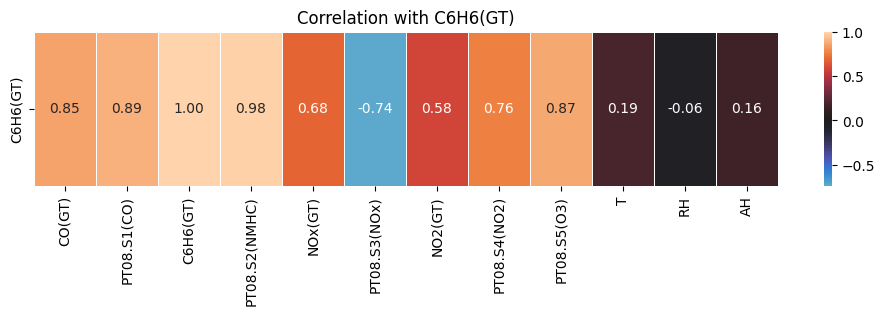

In [ ]:
corr_with_target = data.select_dtypes(include='number').corr()[['C6H6(GT)']].T

plt.figure(figsize=(12, 2))
sns.heatmap(corr_with_target, annot=True, fmt=".2f", center=0, linewidths=0.5)
plt.title('Correlation with C6H6(GT)')
plt.show()

Lets now use another subset of correlated with target variable features. Here we will not use that highly correllated feature PT08.S2(NMHC). Will be chosen another correlated with target variable features. Will be applied different transformations to them, the best set of such transformation wlll be chosen through hyperparameter tuning. Also the best learning rate will be choosen. Also will be two options whether to standardize initial features or not. The best set of all hyperparameters will be then chosen.

In [ ]:
def calculate_vif(features):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = features.columns
    vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    return vif_data

X = data[['PT08.S1(CO)', 'CO(GT)']]
vif_results = calculate_vif(X)
vif_results

Feature       VIF
0  PT08.S1(CO)  5.225536
1       CO(GT)  5.225536

Two features for regression model will be used: PT08.S1(CO) and CO(GT), as they have pretty good linear correlation with target feature. As wee see from VIFs colinearity between these two explaining features exists, but it is not very heavy.   
It was already investigated which transformations to use for these features. In model we are going to use those transformations and additional ones similiar to previously investigated.

In [ ]:
def log_transform(x):
    return np.log1p(x)

def square_root_transform(x):
    return np.sqrt(x)

def square_transform(x):
    return x ** 2

def cube_transform(x):
    return x ** 3

In [ ]:
def tune_hyperparameters(data, columns, transformations, alphas, standardize_options, cv_splits=5, max_iter=1000, tol=1e-3):
    X_raw = data[columns]
    y = data['C6H6(GT)']

    best_mae = float('inf')
    best_alpha = None
    best_transformations = None
    best_standardization = None
    best_residuals = None
    best_r2 = None
    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=42)
    best_coef=[]
    best_intercept=[]

    count = 0
    for standardize in standardize_options:
        for transform_1 in transformations[0]:
            for transform_2 in transformations[1]:
                X_transformed = X_raw.copy()
                X_transformed[columns[0]] = transform_1(X_transformed[columns[0]])
                X_transformed[columns[1]] = transform_2(X_transformed[columns[1]])

                if standardize:
                    scaler = StandardScaler()
                    X_transformed = scaler.fit_transform(X_transformed)
                else:
                    X_transformed = X_transformed.values

                for alpha in alphas:
                    print(f"Parameters: {count}")
                    print(f"Standardize: {standardize}, transform_1: {transform_1}, transform_2: {transform_2}, alpha: {alpha}")

                    maes = []
                    residuals_all = []
                    r2_scores = []
                    coef = []
                    intercept = []

                    for train_index, test_index in kf.split(X_transformed):
                        X_train, X_test = X_transformed[train_index], X_transformed[test_index]
                        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                        model = SGDRegressor(alpha=alpha, max_iter=max_iter, tol=tol, penalty=None,
                                             loss='epsilon_insensitive', random_state=42, epsilon=0.0001)

                        model.fit(X_train, y_train)

                        y_pred = model.predict(X_test)
                        r2 = r2_score(y_test, y_pred)
                        r2_scores.append(r2)
                        residuals = y_test - y_pred
                        residuals_all.extend(residuals)

                        mae = mean_absolute_error(y_test, y_pred)
                        maes.append(mae)

                        coef.append(model.coef_)
                        intercept.append(model.intercept_[0])

                    avg_mae = np.mean(maes)
                    print(f"avg_mae: {avg_mae}")
                    avg_r2 = np.mean(r2_scores)
                    print(f"avg_r2: {avg_r2}")

                    if avg_mae < best_mae:
                        best_mae = avg_mae
                        best_alpha = alpha
                        best_transformations = [transform_1, transform_2]
                        best_standardization = standardize
                        best_residuals = residuals_all
                        best_r2 = avg_r2
                        best_coef = np.mean(coef, axis=0)
                        best_intercept = np.mean(intercept)

                    count += 1


    plt.figure(figsize=(8, 5))
    plt.scatter(range(len(best_residuals)), best_residuals, alpha=0.6, edgecolor='k')
    plt.axhline(0, color='r', linestyle='--', linewidth=1)
    plt.title("Residuals of the Best Model")
    plt.xlabel("Samples")
    plt.ylabel("Residuals")
    plt.grid(True)
    plt.show()

    return {
        'Best Alpha': best_alpha,
        'Best Transformations': [func.__name__ for func in best_transformations],
        'Best Standardization': best_standardization,
        'Best MAE': best_mae,
        'Best R2': best_r2,
        'Best Coef': best_coef,
        'Best Intercept': best_intercept
    }

Parameters: 0
Standardize: True, transform_1: <function square_transform at 0x7f15e276e5f0>, transform_2: <function log_transform at 0x7f15e276c4c0>, alpha: 0.0001
avg_mae: 2.3135095643612305
avg_r2: 0.8205309894263866
Parameters: 1
Standardize: True, transform_1: <function square_transform at 0x7f15e276e5f0>, transform_2: <function log_transform at 0x7f15e276c4c0>, alpha: 0.001
avg_mae: 2.3135095643612305
avg_r2: 0.8205309894263866
Parameters: 2
Standardize: True, transform_1: <function square_transform at 0x7f15e276e5f0>, transform_2: <function log_transform at 0x7f15e276c4c0>, alpha: 0.01
avg_mae: 2.3135095643612305
avg_r2: 0.8205309894263866
Parameters: 3
Standardize: True, transform_1: <function square_transform at 0x7f15e276e5f0>, transform_2: <function log_transform at 0x7f15e276c4c0>, alpha: 0.1
avg_mae: 2.3135095643612305
avg_r2: 0.8205309894263866
Parameters: 4
Standardize: True, transform_1: <function square_transform at 0x7f15e276e5f0>, transform_2: <function square_root_tr

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


avg_mae: 99155283.9401328
avg_r2: -223465703560121.38
Parameters: 17
Standardize: False, transform_1: <function square_transform at 0x7f15e276e5f0>, transform_2: <function log_transform at 0x7f15e276c4c0>, alpha: 0.001


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


avg_mae: 99155283.9401328
avg_r2: -223465703560121.38
Parameters: 18
Standardize: False, transform_1: <function square_transform at 0x7f15e276e5f0>, transform_2: <function log_transform at 0x7f15e276c4c0>, alpha: 0.01


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


avg_mae: 99155283.9401328
avg_r2: -223465703560121.38
Parameters: 19
Standardize: False, transform_1: <function square_transform at 0x7f15e276e5f0>, transform_2: <function log_transform at 0x7f15e276c4c0>, alpha: 0.1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


avg_mae: 99155283.9401328
avg_r2: -223465703560121.38
Parameters: 20
Standardize: False, transform_1: <function square_transform at 0x7f15e276e5f0>, transform_2: <function square_root_transform at 0x7f15e276f130>, alpha: 0.0001


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


avg_mae: 99155283.84341528
avg_r2: -223465703252763.8
Parameters: 21
Standardize: False, transform_1: <function square_transform at 0x7f15e276e5f0>, transform_2: <function square_root_transform at 0x7f15e276f130>, alpha: 0.001


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


avg_mae: 99155283.84341528
avg_r2: -223465703252763.8
Parameters: 22
Standardize: False, transform_1: <function square_transform at 0x7f15e276e5f0>, transform_2: <function square_root_transform at 0x7f15e276f130>, alpha: 0.01


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


avg_mae: 99155283.84341528
avg_r2: -223465703252763.8
Parameters: 23
Standardize: False, transform_1: <function square_transform at 0x7f15e276e5f0>, transform_2: <function square_root_transform at 0x7f15e276f130>, alpha: 0.1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


avg_mae: 99155283.84341528
avg_r2: -223465703252763.8
Parameters: 24
Standardize: False, transform_1: <function cube_transform at 0x7f15e276c1f0>, transform_2: <function log_transform at 0x7f15e276c4c0>, alpha: 0.0001
avg_mae: 191312331086566.16
avg_r2: -1.6733706306696047e+27
Parameters: 25
Standardize: False, transform_1: <function cube_transform at 0x7f15e276c1f0>, transform_2: <function log_transform at 0x7f15e276c4c0>, alpha: 0.001
avg_mae: 191312331086566.16
avg_r2: -1.6733706306696047e+27
Parameters: 26
Standardize: False, transform_1: <function cube_transform at 0x7f15e276c1f0>, transform_2: <function log_transform at 0x7f15e276c4c0>, alpha: 0.01
avg_mae: 191312331086566.16
avg_r2: -1.6733706306696047e+27
Parameters: 27
Standardize: False, transform_1: <function cube_transform at 0x7f15e276c1f0>, transform_2: <function log_transform at 0x7f15e276c4c0>, alpha: 0.1
avg_mae: 191312331086566.16
avg_r2: -1.6733706306696047e+27
Parameters: 28
Standardize: False, transform_1: <functio

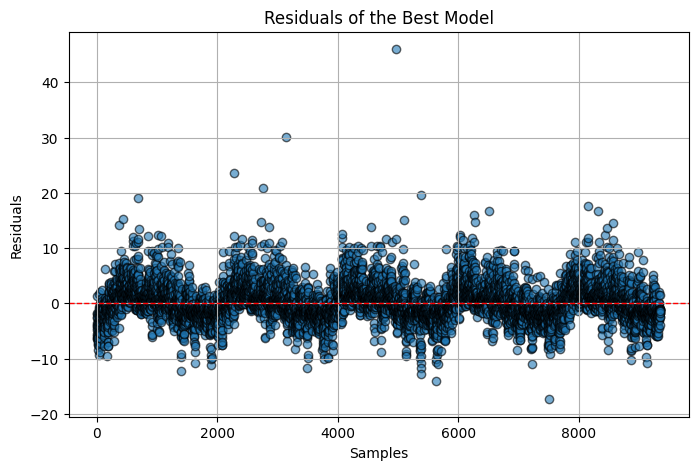

Best Hyperparameters:
Best Alpha: 0.0001
Best Transformations: ['cube_transform', 'square_root_transform']
Best Standardization: True
Metrics for best model:
Best MAE: 2.2727
Best R^2: 0.8256481100437462
Best Coefficients: ['4.4717', '2.6378']
Best Intercept: 9.9293


In [ ]:
independent_variables = ['PT08.S1(CO)', 'CO(GT)']

transformations = [[square_transform, cube_transform],
                    [log_transform, square_root_transform]]
alphas = [0.0001, 0.001, 0.01, 0.1]
standardize_options = [True, False]

results = tune_hyperparameters(data, independent_variables, transformations, alphas, standardize_options, max_iter = 3000)

print("Best Hyperparameters:")
print(f"Best Alpha: {results['Best Alpha']}")
print(f"Best Transformations: {results['Best Transformations']}")
print(f"Best Standardization: {results['Best Standardization']}")
print("Metrics for best model:")
print(f"Best MAE: {results['Best MAE']:.4f}")
print(f"Best R^2: {results['Best R2']}")
best_coef = results['Best Coef']
best_intercept = results['Best Intercept']
formatted_coefficients = [f"{c:.4f}" for c in best_coef]
print(f"Best Coefficients: {formatted_coefficients}")
print(f"Best Intercept: {best_intercept:.4f}")



Tuning of hyperparameters was done. The best transformation for column 'PT08.S1(CO)' was cubic transformation and for 'CO(GT)' was square root transformation. Also we see that the smallest alpha: 0.0001 leads for the best converging of our model. And the standardization is also crucial, as we see, because without standardization MAE values are very big.  

For this model we got higher MAE comparing to first model, one section above. And as well R^2 is lower comparing to first model. It means that this second model captures variablity of target variable in worse extent comparing to first one. Though still pretty big amount of target variable variation is explained , around 82%. MAE metric was choosen as, our data contained outliers, so to make model robust to them.

During stochastic descent another metric was used for optimizing parameters of linear model - epsilon insensitive, with epsilon equal to 0.0001. This was done to approximate desired loss function - MAE. As explicitly sklearn does not support MAE as loss function for SGDRegressor. But this would not lead to very different results , as the epsilon is small.

It seen from coefficients that were assigned by model to independent variables that first independent variable PT08.S1(CO) contributes almost twice as much as second CO(GT) to the model estimation of target variable(because coefficients for them respectively equal to ~4.47 and ~2.64). So we can say that in this model feature PT08.S1(CO) is more important than CO(GT). It is also explaniable as we have seen from correlation matrix of transformed features with target that even after transfomations feature PT08.S1(CO) was correlated better with target , than transformed CO(GT).

Residual plot is similiar to sinusoidal curve. It suggests that there is some periodic trend in our target variable, that is not explained by model. This is explainable as we have seen that sensor values increase at the morning for example and right before evening, it was discovered during EDA. There was not introduced day hour feature in regression model. In order to capture this time dependency of target variable over time, we chould consider another model that will also be referring to day hour when predicting target variable. This would probably refine our model.